In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess
from tqdm import tqdm_notebook
import pprint
import librosa
from IPython.display import clear_output
from scipy.ndimage import convolve
import music21
import madmom
from scipy.signal import convolve2d
from scipy.stats import linregress
import yaml
from multiprocessing import Pool

from msmd.midi_parser import notes_to_onsets, FPS
from msmd.data_model.piece import Piece
from msmd.alignments import align_score_to_performance

/home/mirlab/miniconda3/lib/python3.6/site-packages/madmom/utils/midi.py:116: UserWarning: Deprecated as of version 0.16. Please use madmom.io.midi instead. This module will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.midi '


In [4]:
# path to MSMD dataset
DATA_ROOT_MSMD = '../msmd_aug/msmd_aug'

In [5]:
# obtain all the pieces in the dataset
with open('../msmd/msmd/splits/all_split.yaml', 'r') as f:
    doc = yaml.load(f)
    
pieces = doc['test']
assert len(pieces) == 100

In [6]:
def extractStrips(mungos_per_page):
    """
    Extract a list of staves' mungos objects.
    
    Input: 
        mungos_per_page - a list of mungos per page
        
    Output:
        strips - a list of (page, system_mungo, notehead_mungos) indicating each strip in sequential order.
        where 
            page = page number
            system_mungo = a mungo for a staff
            notehead_mungos = mungos for all noteheads in that page
    """
    strips = []
    
    page_num = len(mungos_per_page)
    for page in range(page_num):
        system_mungos = [c for c in mungos_per_page[page] if c.clsname == 'staff']
        system_mungos = sorted(system_mungos, key=lambda m: m.top)
        notehead_mungos = [c for c in mungos_per_page[page] if c.clsname == 'notehead-full']
        for system_mungo in system_mungos:
            strips.append((page, system_mungo, notehead_mungos))
    
    return strips

In [7]:
def convertMungoToImage(system_mungo, notehead_mungos, image, page_num,
                        marginLeftRatio=0,
                        marginRightRatio=0,
                        marginTopRatio=0.45, 
                        marginBottomRatio=0.45,
                        verbose=True):
    """
    Convert staff location information from mungo to an actual image.
    
    Input:
        system_mungo - mungo for a staff line
        notehead_mungos - mungos for noteheads
        image - an image of the page corresponding to the system_mungo
        
    Output:
        image - an image in np.array whose values are np.int8
    
    """
    
    # Get the bounding box of the staff
    (y_top, x_left, y_bottom, x_right) = system_mungo.bounding_box
    height = y_bottom - y_top
    width = x_right - x_left
    
    # Calculate the vertical margins
    marginTop = min(int(round(marginTopRatio * height)), y_top)  #  Prevent out-of-page margin
    marginBottom = min(int(round(marginBottomRatio * height)), image.shape[0] - y_bottom) #  Prevent out-of-page margin
     
    # Calculate the starting and ending vertical positions
    y_start = y_top - marginTop
    y_end = y_bottom + marginBottom
    
    # Calculate the horizontal margins
    marginLeft = min(int(round(marginLeftRatio * width)), x_left) # Prevent out-of-page margin
    marginRight = min(int(round(marginRightRatio * width)), image.shape[1] - x_right) # Prevent out-of-page margin
    
    # Calculate the starting and ending horizontal positions
    x_start = x_left - marginLeft
    x_end = x_right + marginRight
    
    # Plot noteheads
    out_mungos = {}
    for n in notehead_mungos:
        if x_start <= n.middle[1] < x_end and y_start <= n.middle[0] < y_end:
            # Add notes to the output list
            n.translate(down=-y_start, right=-x_start)
            out_mungos[n.objid] = n
            if verbose:
                plt.plot(n.middle[1] - x_start, n.middle[0] - y_start, 'bo', alpha=0.5)
    
    if verbose:
        plt.imshow(image[y_start:y_end,x_start:x_end], cmap="gray")
        plt.show()
        
    return image[y_start:y_end, x_start:x_end], out_mungos

In [8]:
def calcErrorStats(errs, tols):
    errorRates = []
    for tol in tols:
        toAdd = np.sum(np.abs(errs) >= tol) / len(errs)
        errorRates.append(toAdd)
        
    avgError = np.average(np.abs(errs))
    stdError = np.std(np.abs(errs))
    return errorRates, avgError, stdError

In [9]:
def processPiece(piece_idx, debug=False):
    piece_name = pieces[piece_idx]
    
    # Load the piece and score
    piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
    assert len(piece.available_scores) == 1
    score = piece.load_score(piece.available_scores[0])
    images = score.load_images()
    
    # Get mungos
    mungos = score.load_mungos()
    mdict = {m.objid: m for m in mungos}
    mungos_per_page = score.load_mungos(by_page=True)
    
    # Extract strips
    strips = extractStrips(mungos_per_page)
    strip_images = []
    note_mango_dict = {}
    for (strip_num, (page, system_mungo, note_mungos)) in enumerate(strips):
        strip_image, out_mungos = convertMungoToImage(system_mungo, 
                                                      note_mungos, 
                                                      images[page], 
                                                      page,
                                                      verbose=False)
        strip_images.append(strip_image)
        for n in out_mungos:
            note_mango_dict[n] = (strip_num, out_mungos[n])
    
    # Compute base x refs
    base_x_strips = [0]
    for strip_num in range(1,len(strip_images)):
        base_x_strips.append(base_x_strips[strip_num - 1] + strip_images[strip_num - 1].shape[1])
    
    # Enumerate over all performances
    output = {}
    for performance_name in piece.available_performances:   
        if not performance_name.endswith('tempo-1000_grand-piano-YDP-20160804'): continue
        
        # Get performance path
        performance_path = os.path.join(DATA_ROOT_MSMD, piece_name, 'performances', performance_name)
        
        if not os.path.exists(os.path.join(performance_path, 'output.npy')):
            print("No spectrogram")
            continue
        
        # Get the alignment
        performance = piece.load_performance(performance_name, require_audio=False)
        alignment = align_score_to_performance(score, performance)
        note_events = performance.load_note_events()
        
        # Get prediction [dtw]
        prediction = np.load(os.path.join(performance_path, 'output.npy'))
        wp = prediction.item().get('wp')
        wp_salient = prediction.item().get('wp-salient')
        zeroPad = prediction.item().get('zeroPad')
        factor = prediction.item().get('factor')
        pred_loc, rescaled_spec_loc = zip(*wp)
        pred_loc_salient, rescaled_spec_loc_salient = zip(*wp_salient)
        
        errs_dtw = []
        errs_salient = []
        errs_global_linear = []
        for alignment_idx in range(len(alignment)):
            m_objid, e_idx = alignment[alignment_idx]
            strip_num, note_object = note_mango_dict[m_objid]
            midi_event = note_events[e_idx]
        
            # given the midi note event we compute the corresponding onset frame
            dt = 1.0 / FPS
            onset_frame = int(np.ceil(midi_event[0] / dt))
        
            # gt loc
            gt_x = base_x_strips[strip_num] + note_object.middle[1]
            
            # spec_loc
            spec_x = onset_frame
            
            # rescaled_spec
            rescaled_spec_x = spec_x * factor + zeroPad
            
            # pred loc
            pred_x = np.interp(rescaled_spec_x, rescaled_spec_loc, pred_loc)
            
            # pred loc salient
            pred_x_salient = np.interp(rescaled_spec_x, rescaled_spec_loc_salient, pred_loc_salient)
            
            # pred loc [global_linear]
            pred_x_global_linear = np.interp(rescaled_spec_x, wp[[0,-1],0], wp[[0,-1],1])
            
            if debug:
                print("gt_x = {}    spec_x = {}    resclaed_spec_x = {}   pred_x = {} err = {}".format(gt_x, 
                                                                                              spec_x, 
                                                                                              rescaled_spec_x,
                                                                                              pred_x, pred_x - gt_x))
            
            errs_dtw.append(pred_x - gt_x)
            errs_salient.append(pred_x_salient - gt_x)
            errs_global_linear.append(pred_x_global_linear - gt_x)
            
        
        if debug:
            tols = np.arange(100)
            errorRates, avgError, stdError = calcErrorStats(errs_dtw, tols)
            errorRates_salient, _, _ = calcErrorStats(errs_salient, tols)
            errorRates_glob, _, _ = calcErrorStats(errs_global_linear, tols)
            plt.plot(tols, errorRates, label='dtw')
            plt.plot(tols, errorRates_salient, label='salient')
            plt.plot(tols, errorRates_glob, label='global linear')
            plt.grid()
            plt.legend()
            plt.xlabel("Error Tolerance (px)")
            plt.ylabel("Error Rate (pixels)")
            plt.title("Average Error = {:.2f} px (std = {:.2f})".format(avgError, stdError))
            plt.show()

        output[performance_name] = (errs_dtw, errs_salient, errs_global_linear)
    return output

gt_x = 95    spec_x = 0    resclaed_spec_x = 50   pred_x = 40.0 err = -55.0
gt_x = 111    spec_x = 4    resclaed_spec_x = 74   pred_x = 74.0 err = -37.0
gt_x = 126    spec_x = 7    resclaed_spec_x = 92   pred_x = 110.0 err = -16.0
gt_x = 126    spec_x = 7    resclaed_spec_x = 92   pred_x = 110.0 err = -16.0
gt_x = 141    spec_x = 10    resclaed_spec_x = 110   pred_x = 142.0 err = 1.0
gt_x = 157    spec_x = 14    resclaed_spec_x = 134   pred_x = 166.0 err = 9.0
gt_x = 172    spec_x = 17    resclaed_spec_x = 152   pred_x = 187.0 err = 15.0
gt_x = 195    spec_x = 20    resclaed_spec_x = 170   pred_x = 198.0 err = 3.0
gt_x = 211    spec_x = 23    resclaed_spec_x = 188   pred_x = 212.0 err = 1.0
gt_x = 226    spec_x = 27    resclaed_spec_x = 212   pred_x = 231.0 err = 5.0
gt_x = 226    spec_x = 27    resclaed_spec_x = 212   pred_x = 231.0 err = 5.0
gt_x = 241    spec_x = 30    resclaed_spec_x = 230   pred_x = 248.0 err = 7.0
gt_x = 257    spec_x = 33    resclaed_spec_x = 248   pred_x = 262.

gt_x = 3880    spec_x = 601    resclaed_spec_x = 3656   pred_x = 3645.0 err = -235.0
gt_x = 3880    spec_x = 601    resclaed_spec_x = 3656   pred_x = 3645.0 err = -235.0
gt_x = 3901    spec_x = 604    resclaed_spec_x = 3674   pred_x = 3669.0 err = -232.0
gt_x = 3922    spec_x = 607    resclaed_spec_x = 3692   pred_x = 3686.0 err = -236.0
gt_x = 3922    spec_x = 607    resclaed_spec_x = 3692   pred_x = 3686.0 err = -236.0
gt_x = 3922    spec_x = 607    resclaed_spec_x = 3692   pred_x = 3686.0 err = -236.0
gt_x = 3949    spec_x = 614    resclaed_spec_x = 3734   pred_x = 3707.0 err = -242.0
gt_x = 3964    spec_x = 617    resclaed_spec_x = 3752   pred_x = 3728.0 err = -236.0
gt_x = 3984    spec_x = 620    resclaed_spec_x = 3770   pred_x = 3748.0 err = -236.0
gt_x = 3984    spec_x = 620    resclaed_spec_x = 3770   pred_x = 3748.0 err = -236.0
gt_x = 3984    spec_x = 620    resclaed_spec_x = 3770   pred_x = 3748.0 err = -236.0
gt_x = 4021    spec_x = 627    resclaed_spec_x = 3812   pred_x = 

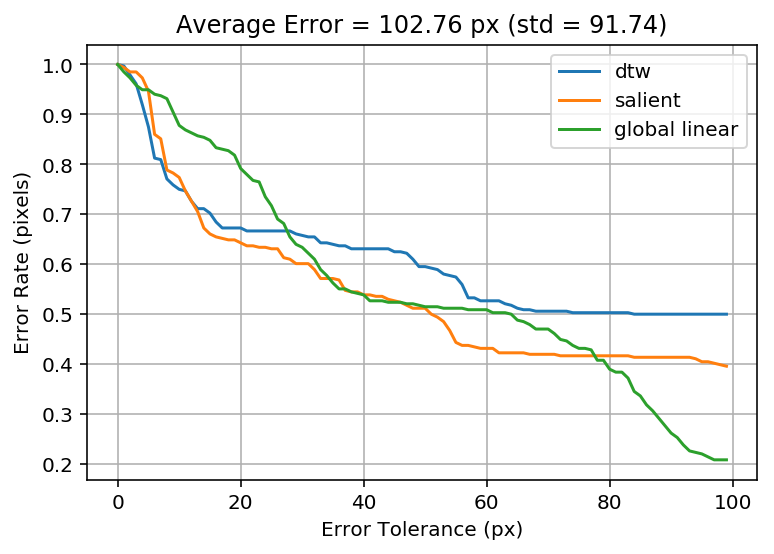

{'MozartWA__KV331__KV331_1_2_var1_tempo-1000_grand-piano-YDP-20160804': ([-55.0,
   -37.0,
   -16.0,
   -16.0,
   1.0,
   9.0,
   15.0,
   3.0,
   1.0,
   5.0,
   5.0,
   7.0,
   5.0,
   3.0,
   4.0,
   4.0,
   7.0,
   7.0,
   3.0,
   3.0,
   5.0,
   12.0,
   1.0,
   7.0,
   7.0,
   4.0,
   0.0,
   12.0,
   3.0,
   4.0,
   8.0,
   8.0,
   34.0,
   44.0,
   58.0,
   63.0,
   65.0,
   62.0,
   62.0,
   67.0,
   73.0,
   83.0,
   11.0,
   11.0,
   11.0,
   5.0,
   3.0,
   4.0,
   5.0,
   5.0,
   5.0,
   1.0,
   2.0,
   2.0,
   2.0,
   4.0,
   5.0,
   2.0,
   4.0,
   8.0,
   7.0,
   7.0,
   7.0,
   7.0,
   2.0,
   9.0,
   8.0,
   5.0,
   5.0,
   5.0,
   -4.0,
   3.0,
   3.0,
   3.0,
   9.0,
   4.0,
   4.0,
   4.0,
   1.0,
   5.0,
   14.0,
   14.0,
   14.0,
   4.0,
   4.0,
   4.0,
   4.0,
   -2.0,
   7.0,
   7.0,
   7.0,
   7.0,
   3.0,
   5.0,
   5.0,
   5.0,
   5.0,
   -3.0,
   5.0,
   5.0,
   5.0,
   5.0,
   10.0,
   12.0,
   12.0,
   12.0,
   6.0,
   1.0,
   3.0,
   3.0,
   3.0,
   -64.

In [10]:
processPiece(2, debug=True)

In [11]:
with Pool(12) as p:
    output = list(tqdm_notebook(p.imap(processPiece, range(len(pieces))), total=len(pieces)))

In [12]:
output_dict = {}
for piece_idx in range(len(output)):
    output_piece = {}
    for key in output[piece_idx]:
        output_piece[key] = output[piece_idx][key]
    output_dict[pieces[piece_idx]] = output_piece

In [13]:
keys = list(output_dict.keys())
for piece in tqdm_notebook(keys):
    dorfer_errs = np.load('./dorfer_results/{}.csv.npy'.format(piece))
    old_errs = output_dict[piece]
    if len(old_errs) == 0: continue
        
    tmp_key = None
    tmp = None
    for key in old_errs:
        tmp_key = key
        tmp = old_errs[key]
        break
    
    output_dict[piece] = {
        tmp_key: (tmp[0], tmp[1], tmp[2], dorfer_errs.item().get('alignment_errors'))
    }

In [14]:
def aggregateResult(errs_dict, tols=np.arange(100), 
                    markers=['.','v','^','x','D','h','*'],
                    debug=False):
    errs = []
    errs_salient = []
    errs_global_linear = []
    errs_dorfer = []
    for piece in tqdm_notebook(errs_dict):
        if len(errs_dict[piece]) == 0: continue
        
        piece_errs = []
        piece_errs_salient = []
        piece_errs_global_linear = []
        piece_errs_dorfer = []
        if debug:
            plt.figure()
            
        for i, performance in enumerate(errs_dict[piece]):
            piece_errs.extend(errs_dict[piece][performance][0])
            piece_errs_salient.extend(errs_dict[piece][performance][1])
            piece_errs_global_linear.extend(errs_dict[piece][performance][2])
            piece_errs_dorfer.extend(errs_dict[piece][performance][3])
        
            if debug:
                errorRates, avgError, stdError = calcErrorStats(errs_dict[piece][performance][0], tols)
                label_name = 'Ours'
                
                plt.plot(tols, errorRates, label=label_name, marker=markers[i], alpha=0.5)
                
                errorRates, avgError, stdError = calcErrorStats(errs_dict[piece][performance][1], tols)
                label_name = 'Salient'
                
                plt.plot(tols, errorRates, label=label_name, marker=markers[i], alpha=0.5)
                
                errorRates_global_linear, _, _ = calcErrorStats(errs_dict[piece][performance][2], tols)
                label_name = 'Global Linear'
                
                plt.plot(tols, errorRates_global_linear, label=label_name, marker=markers[(i+1) % len(markers)], alpha=0.5)
                
                errorRates_dorfer, _, _ = calcErrorStats(errs_dict[piece][performance][3], tols)
                label_name = 'Dorfer'
                
                plt.plot(tols, errorRates_dorfer, label=label_name, marker=markers[(i+1) % len(markers)], alpha=0.5)
                
        if debug:
            plt.grid()
            plt.legend(loc='best')
            plt.xlabel("Error Tolerance (px)")
            plt.ylabel("Error Rate")
            plt.ylim([0,1])
            plt.title("{} (avg = {:.2f}, std = {:.2f})".format(piece, avgError, stdError))
            plt.show()
    
        errs.extend(piece_errs)
        errs_salient.extend(piece_errs_salient)
        errs_global_linear.extend(piece_errs_global_linear)
        errs_dorfer.extend(piece_errs_dorfer)
    return (calcErrorStats(errs, tols), 
            calcErrorStats(errs_salient, tols),
            calcErrorStats(errs_global_linear, tols),
            calcErrorStats(errs_dorfer, tols))

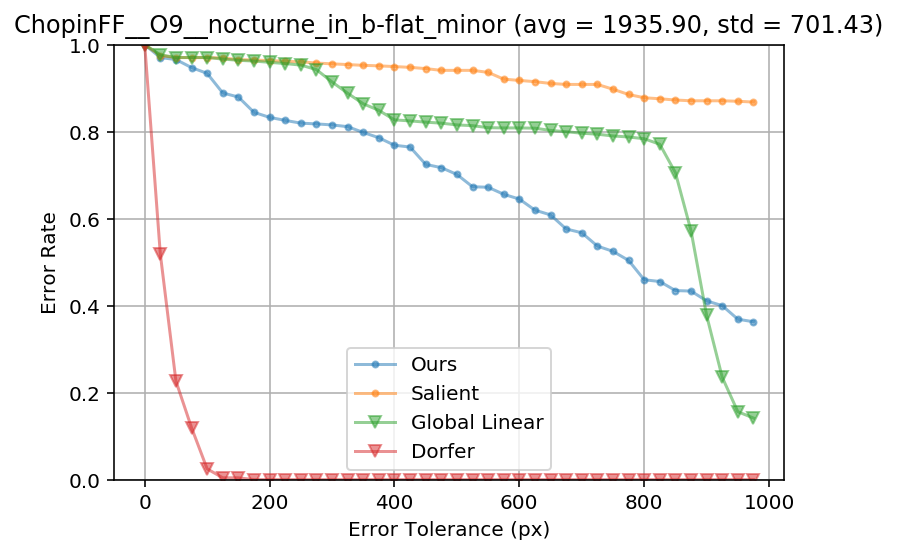

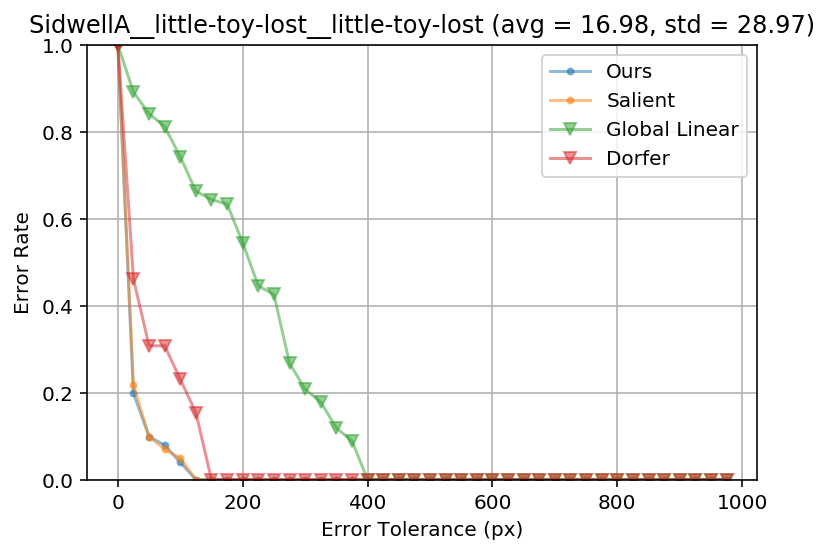

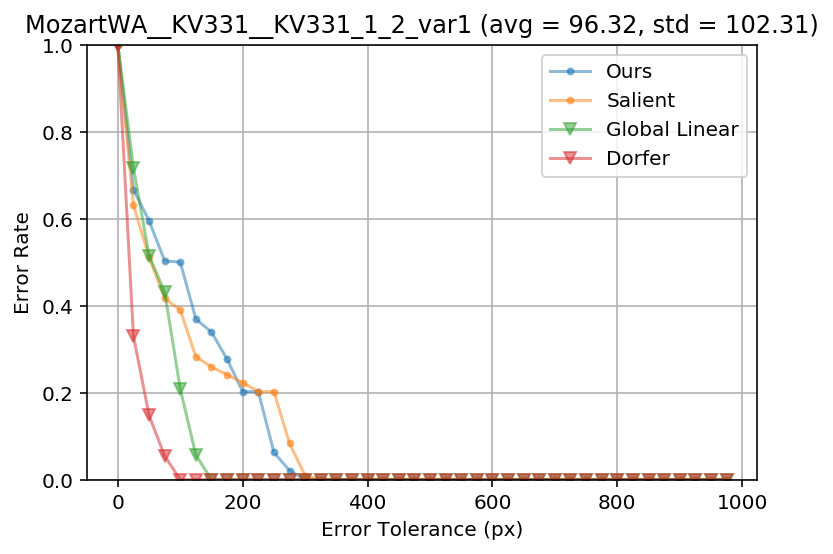

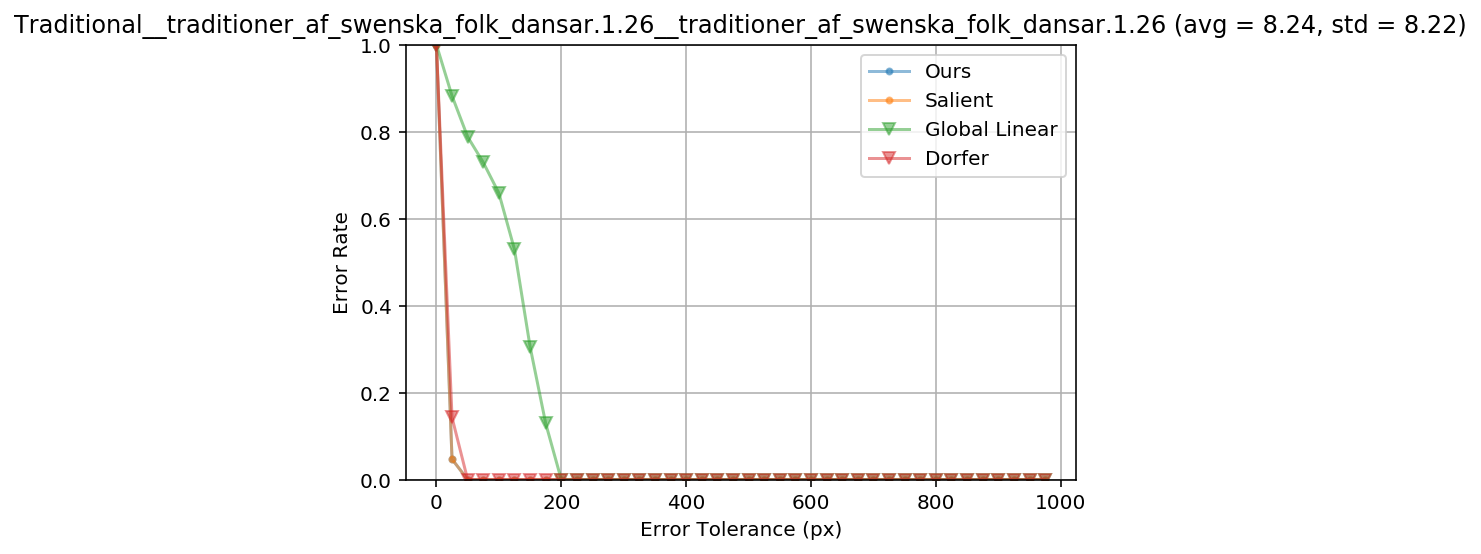

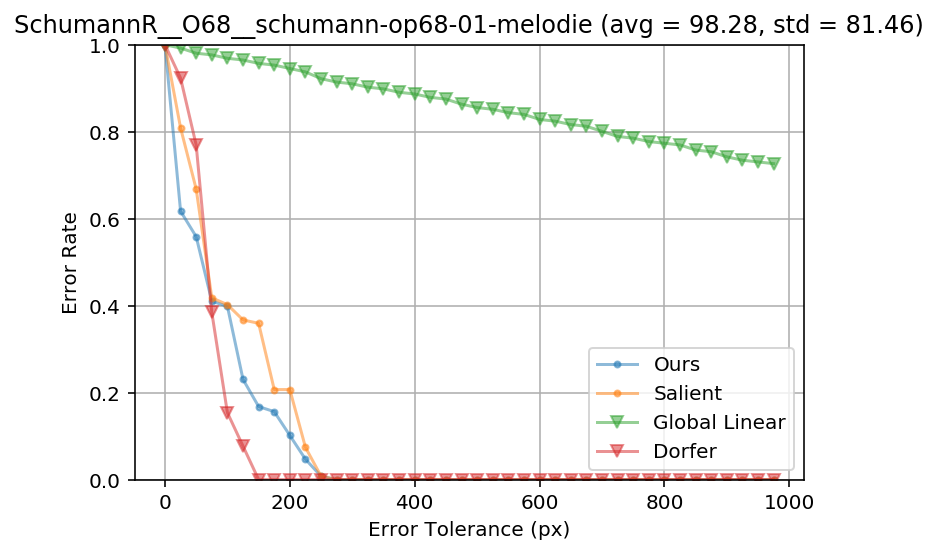

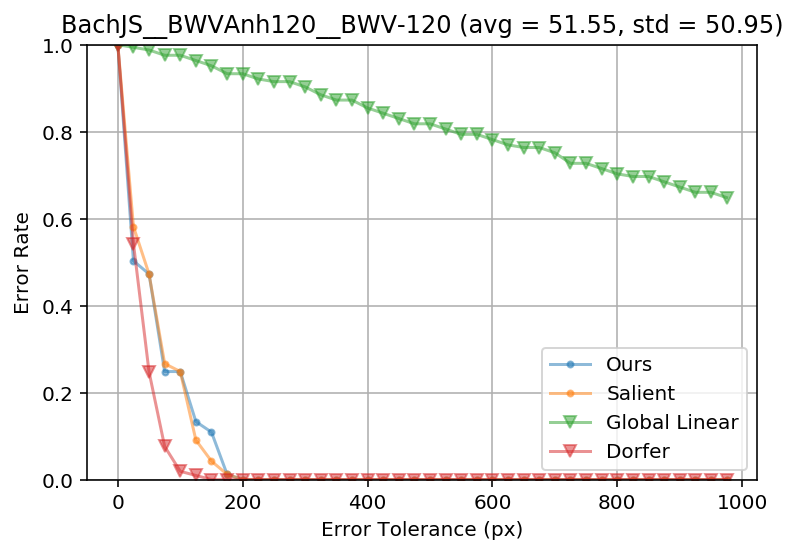

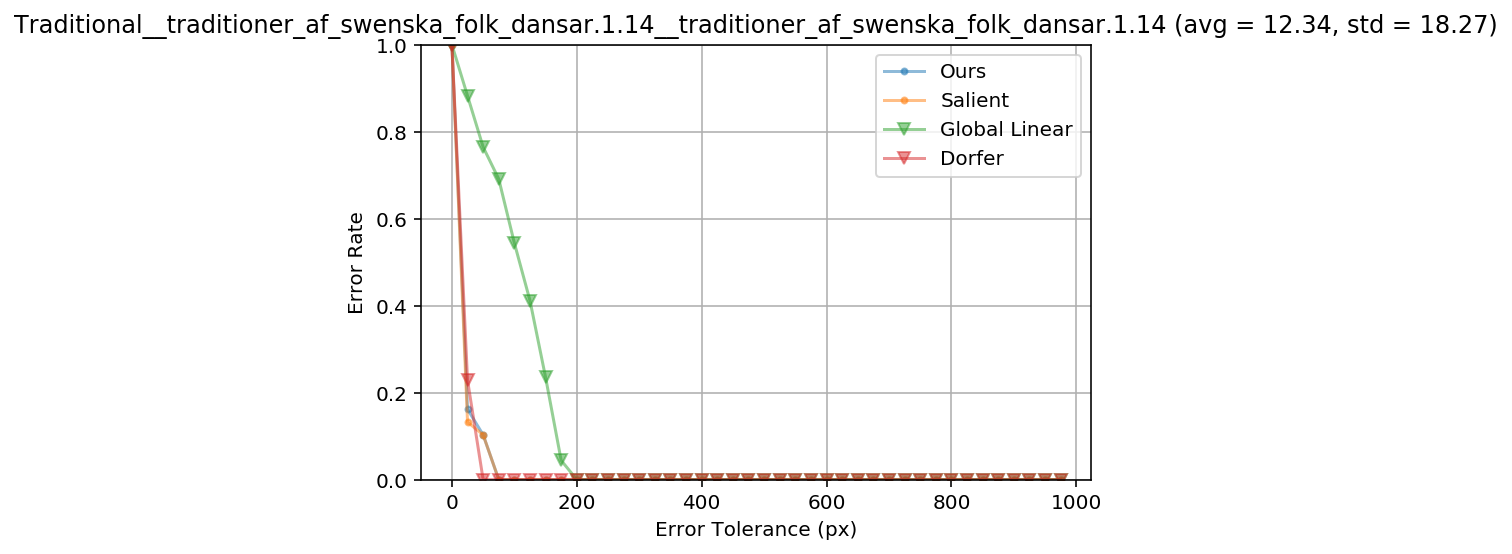

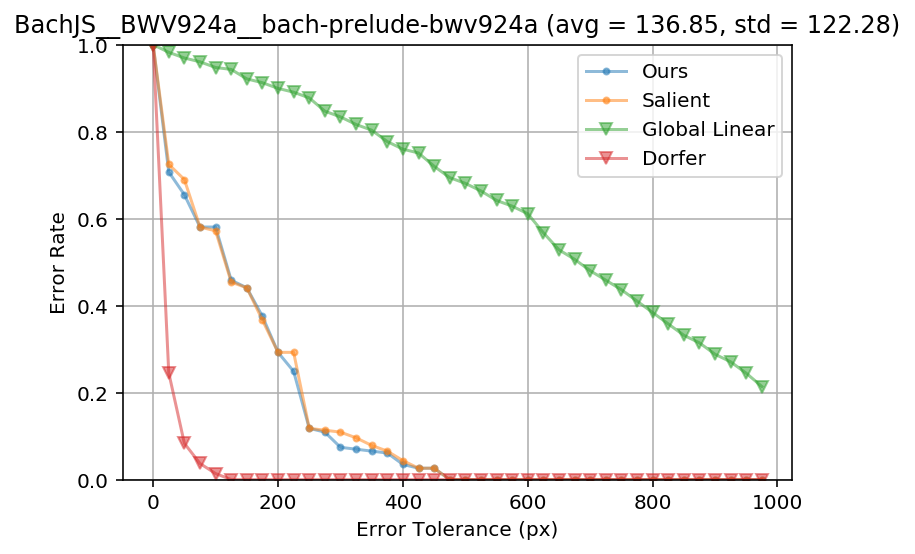

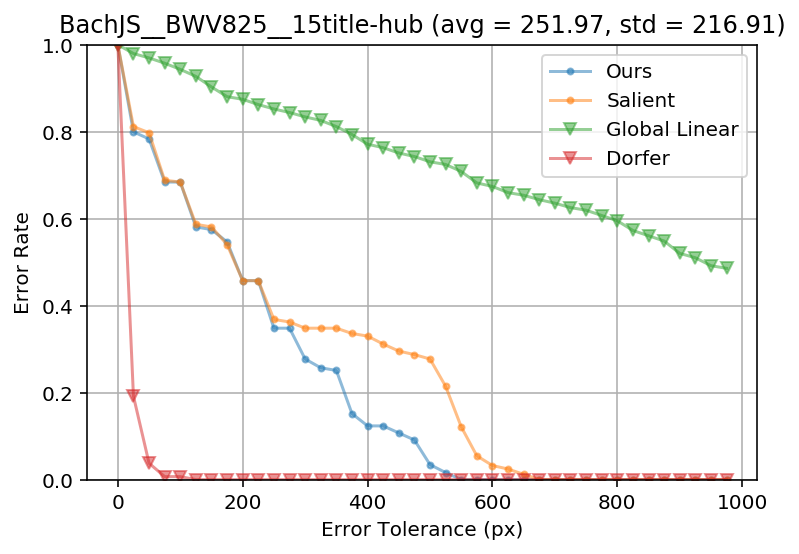

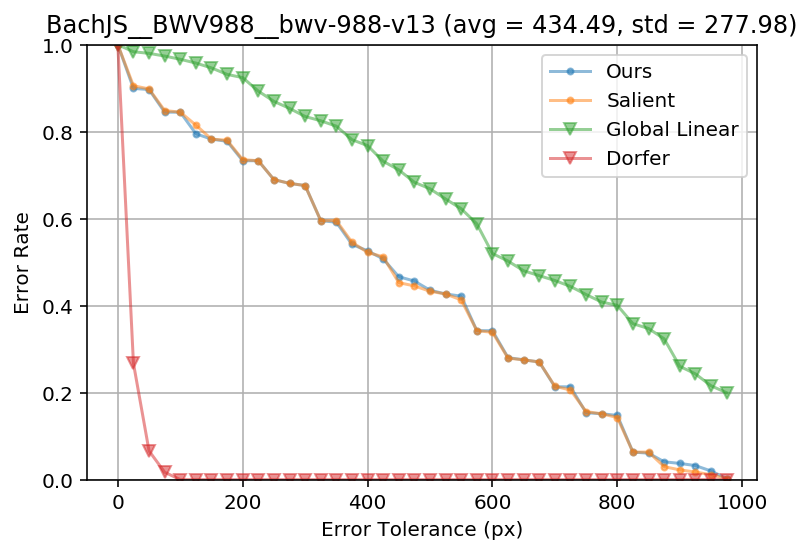

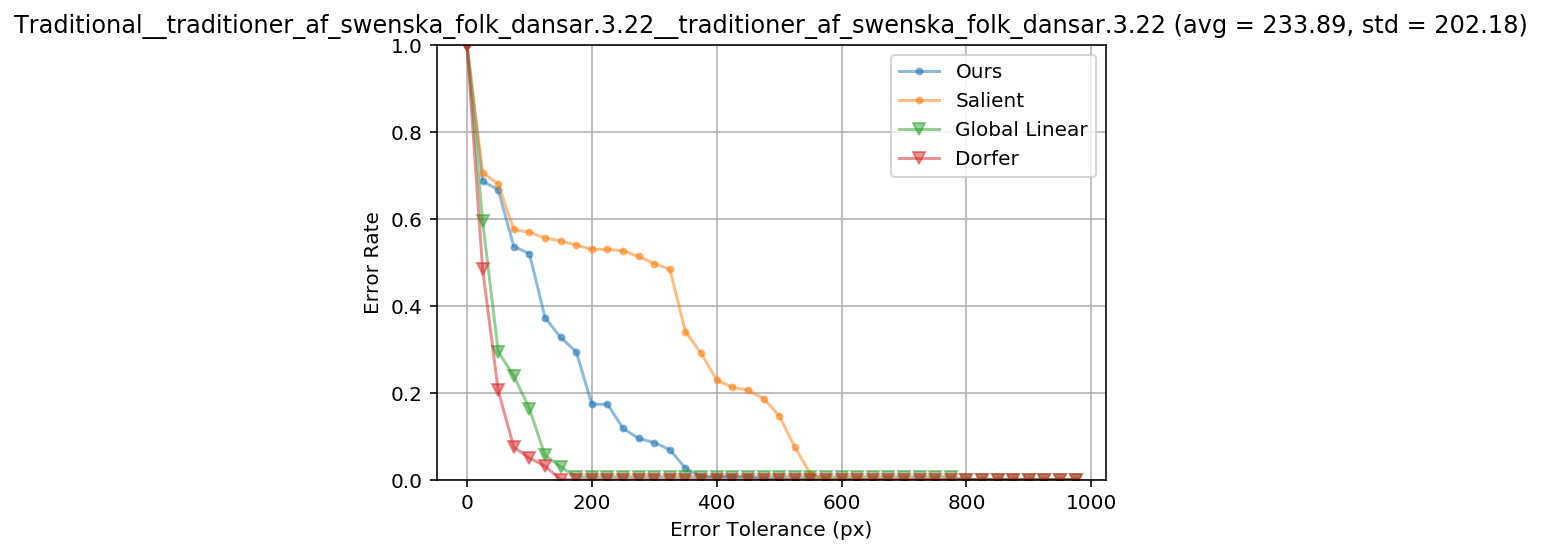

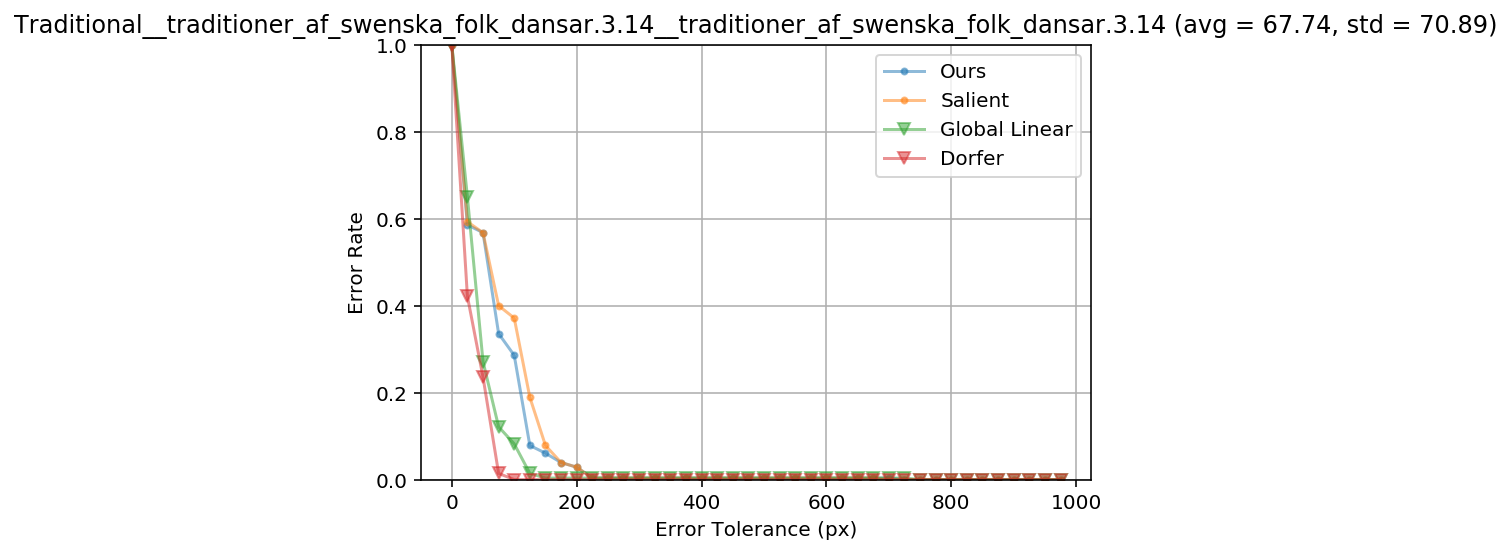

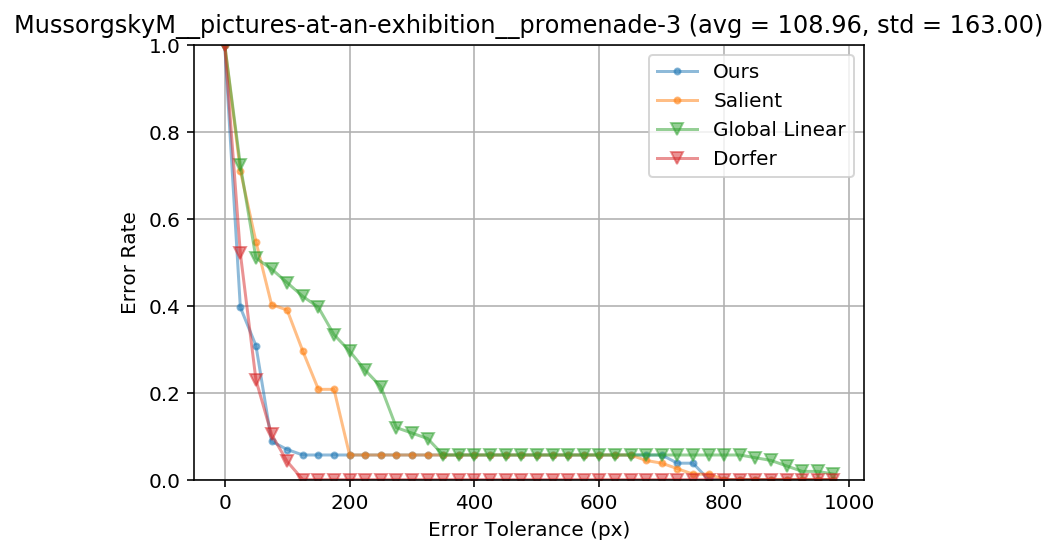

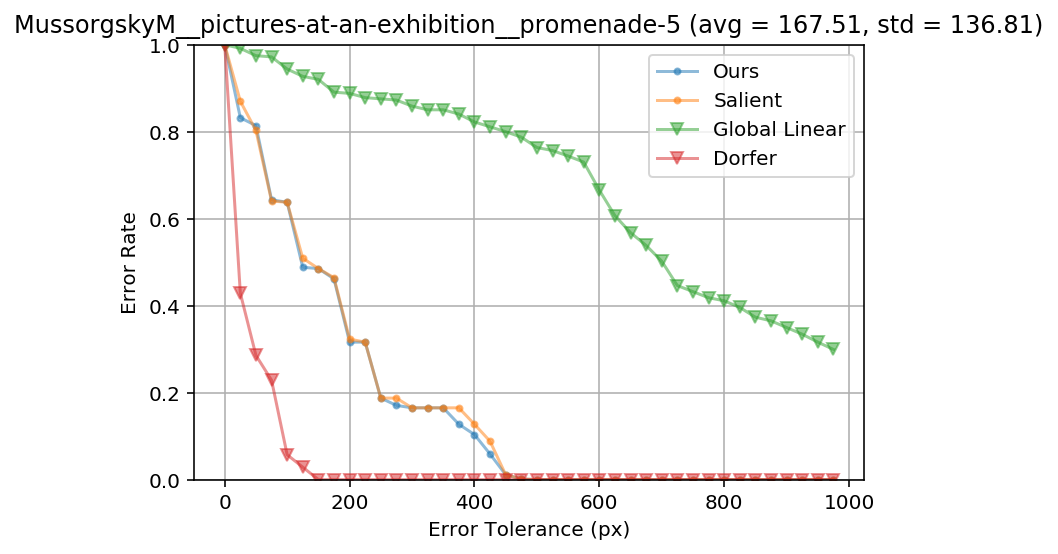

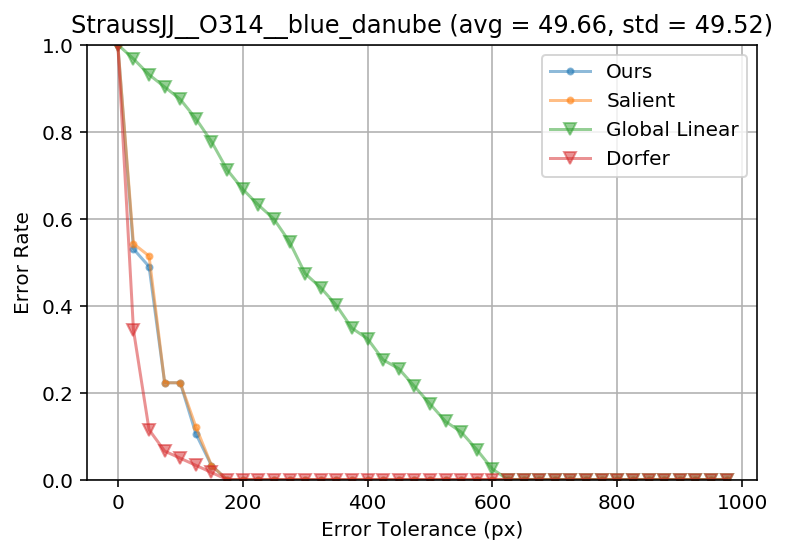

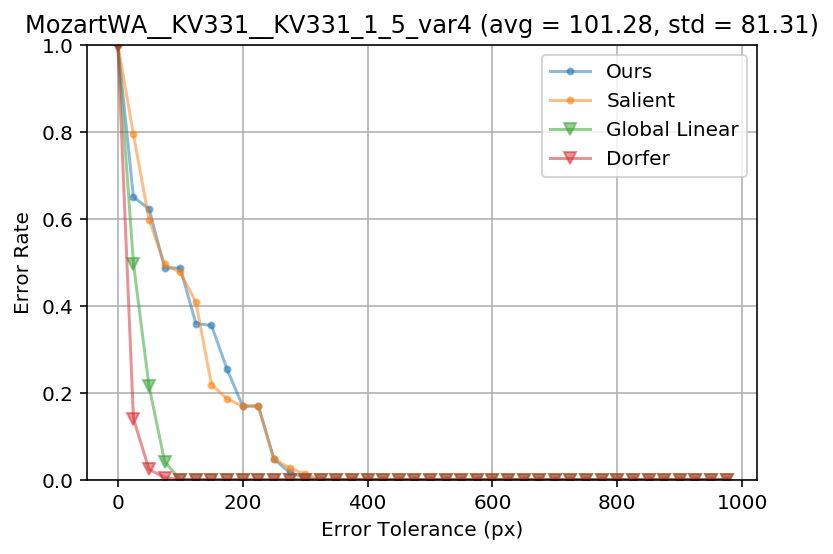

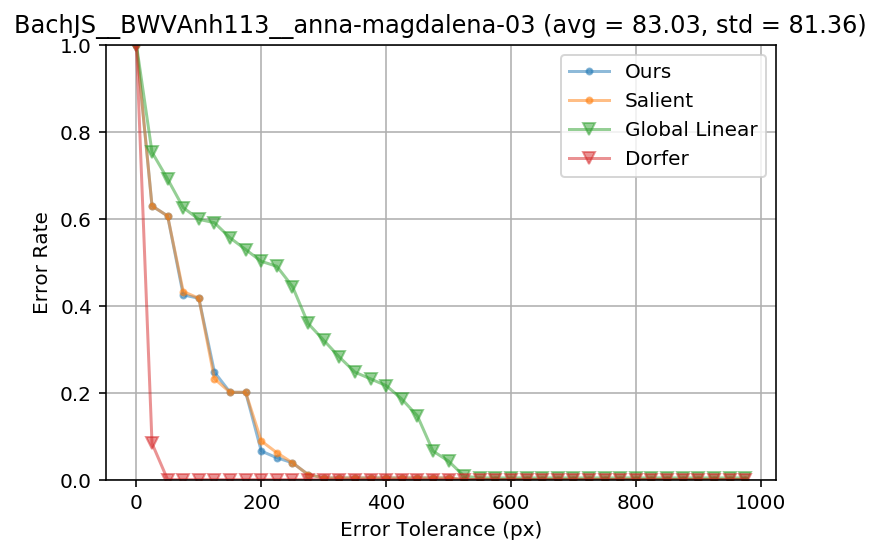

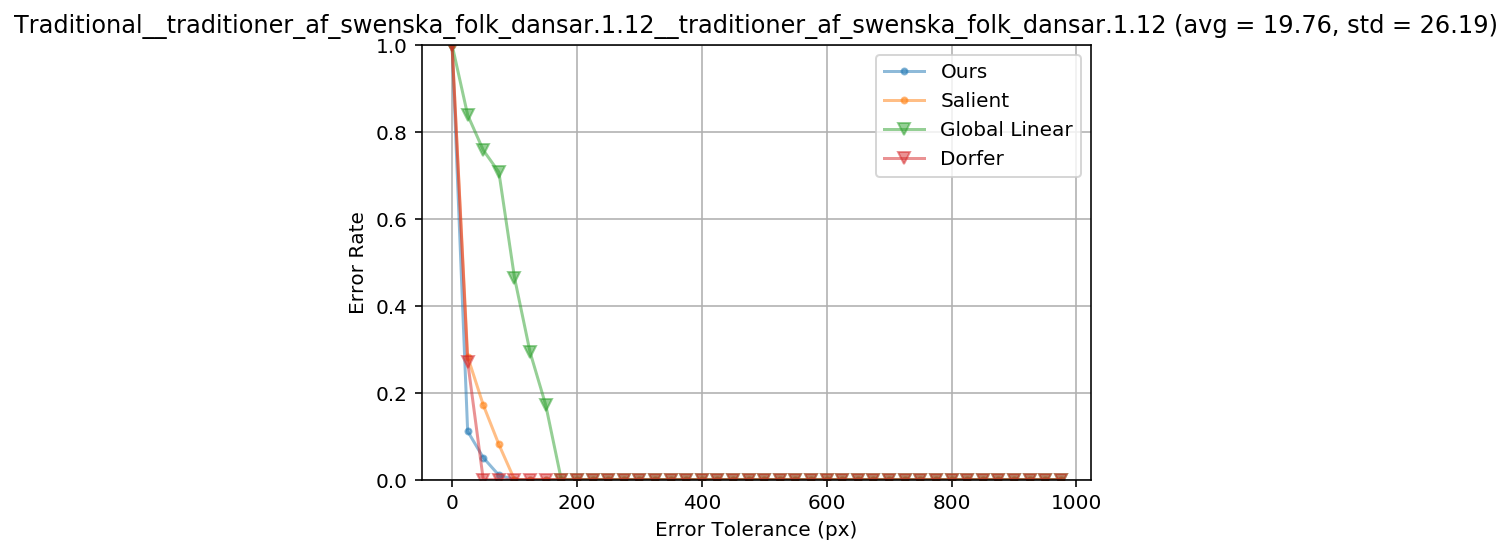

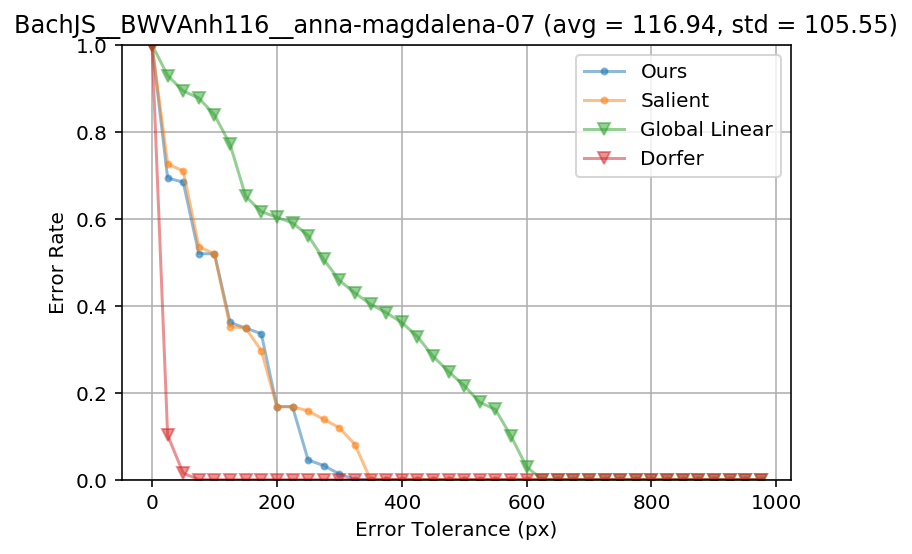

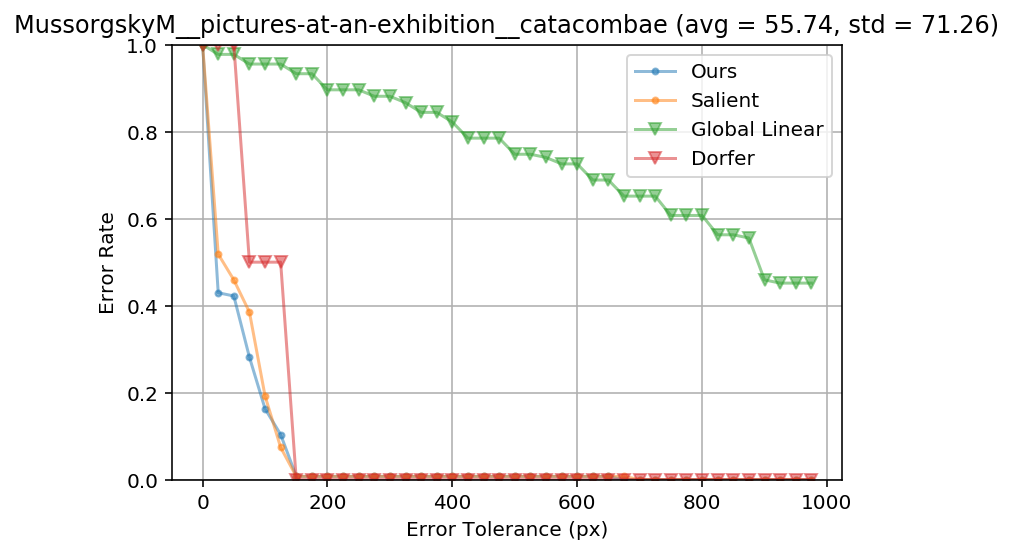

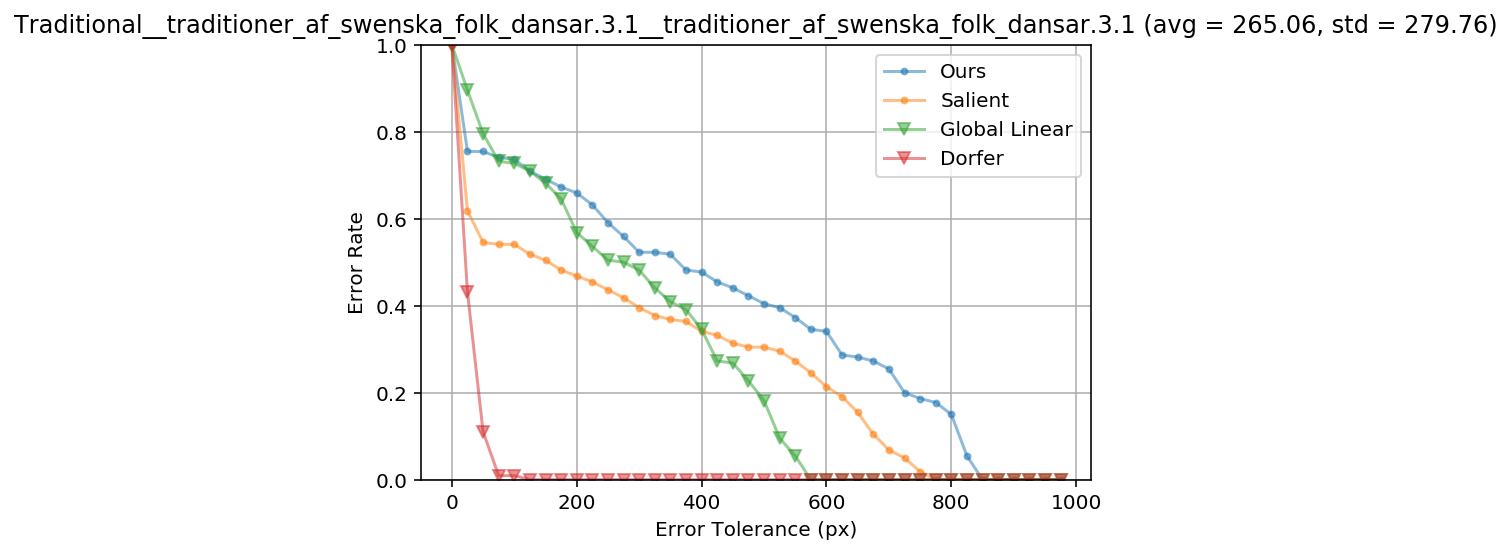

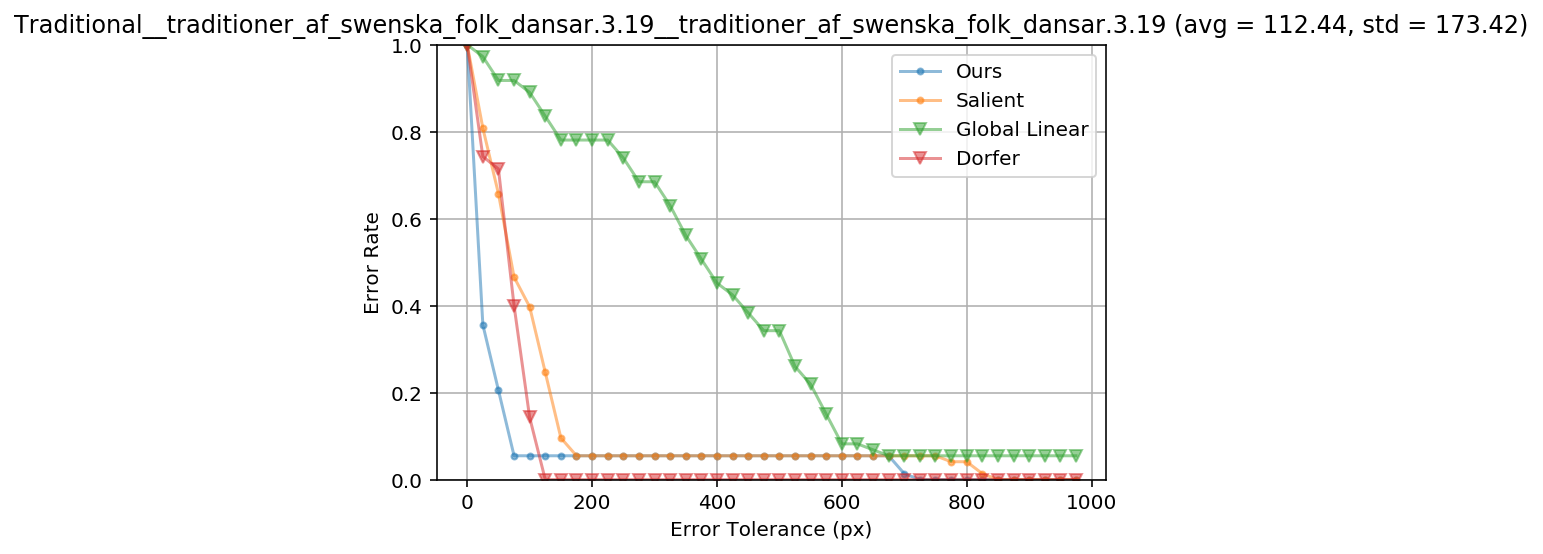

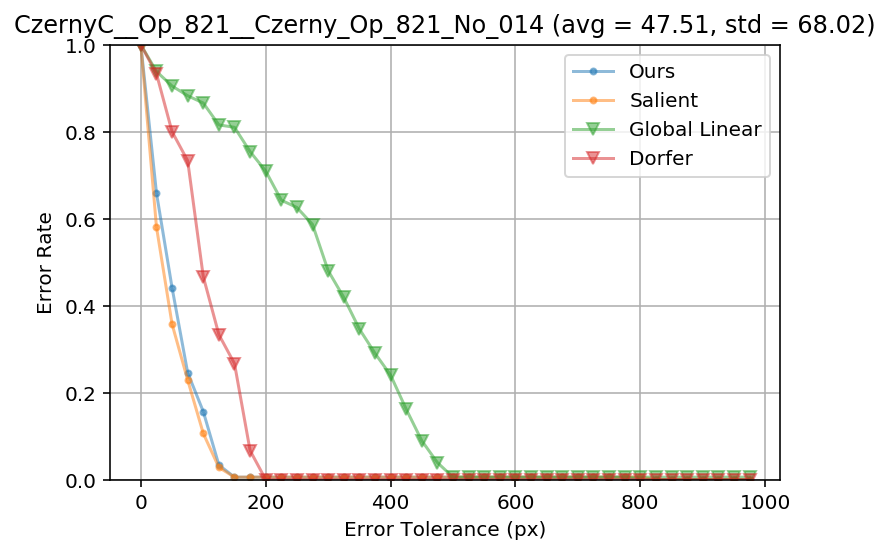

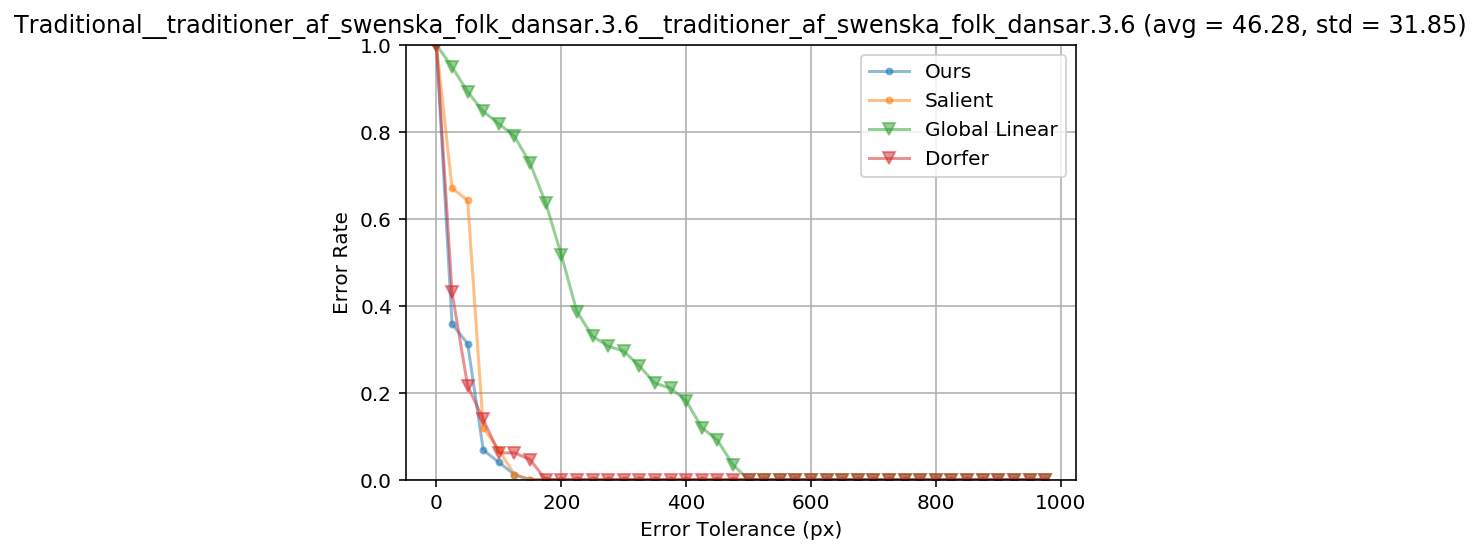

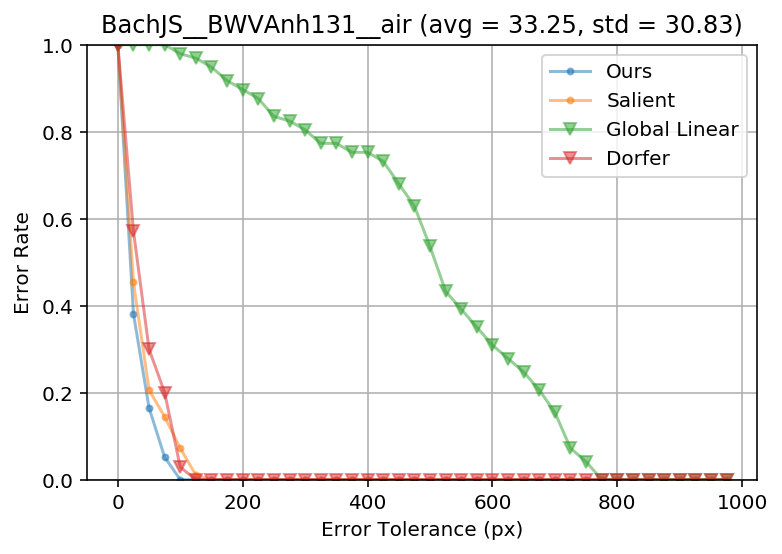

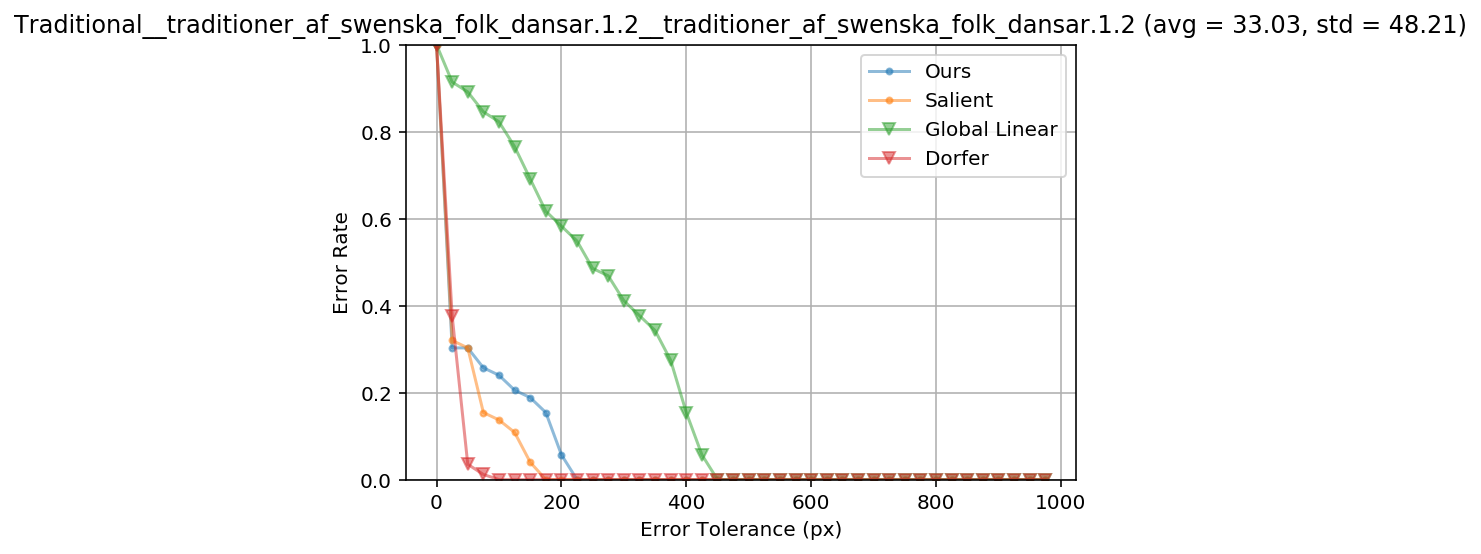

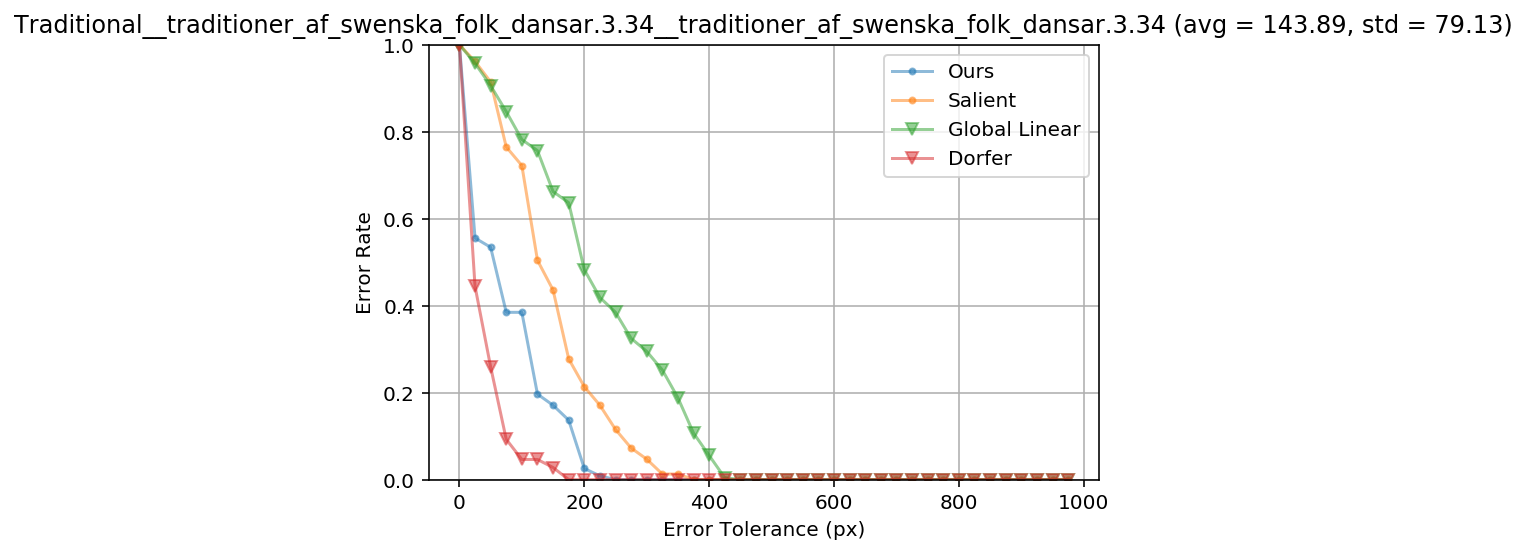

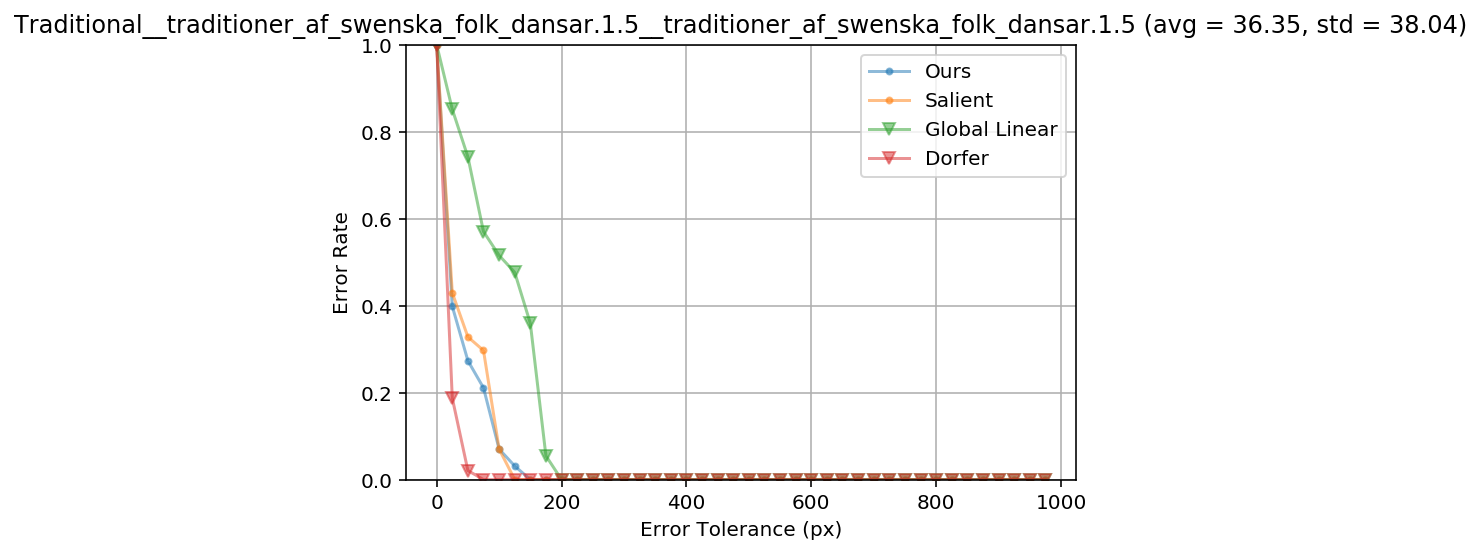

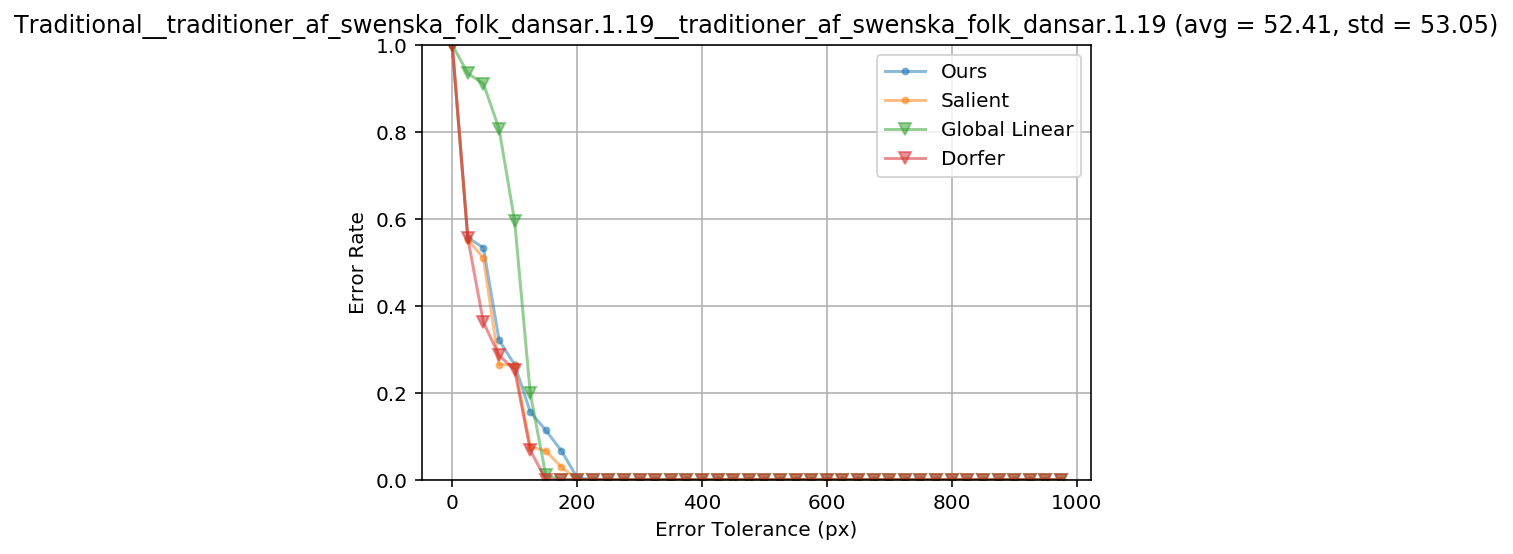

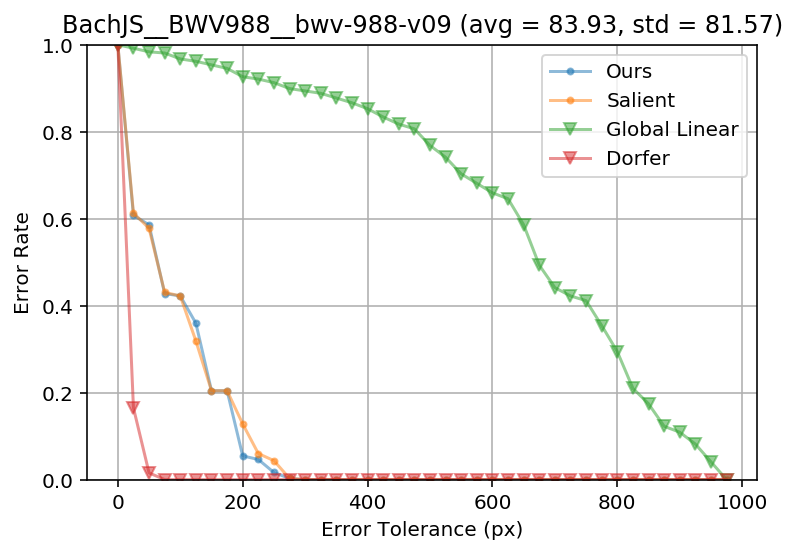

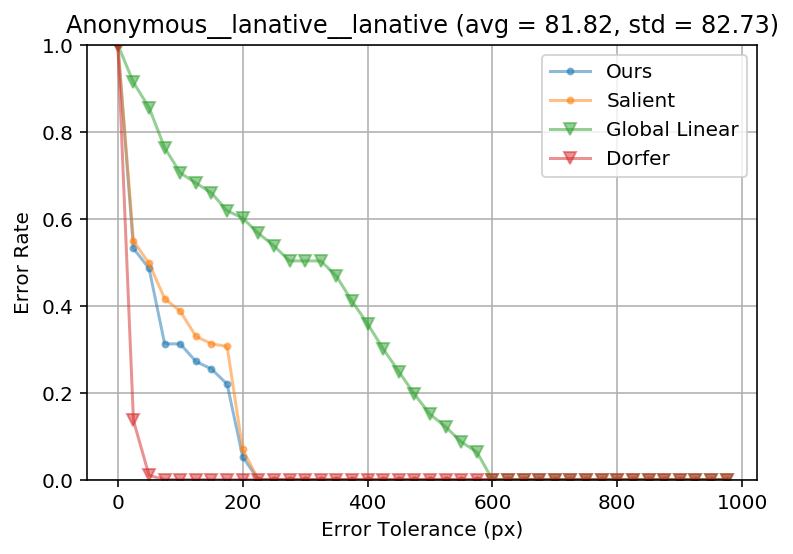

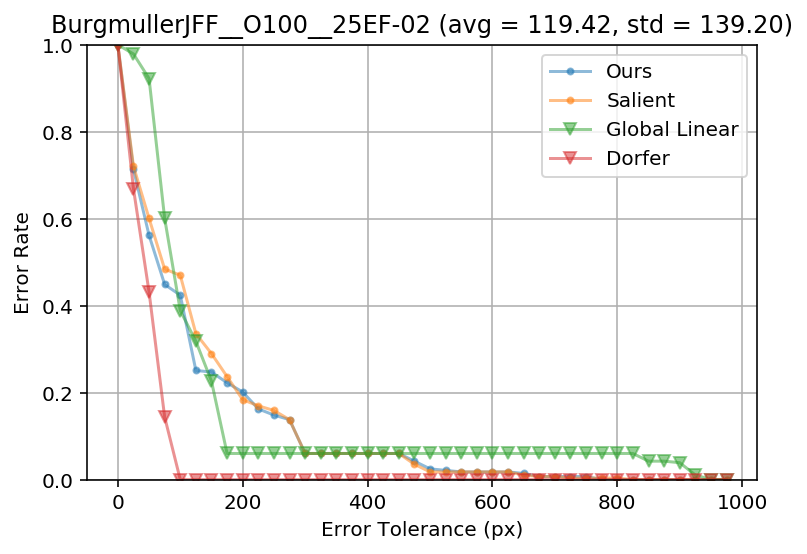

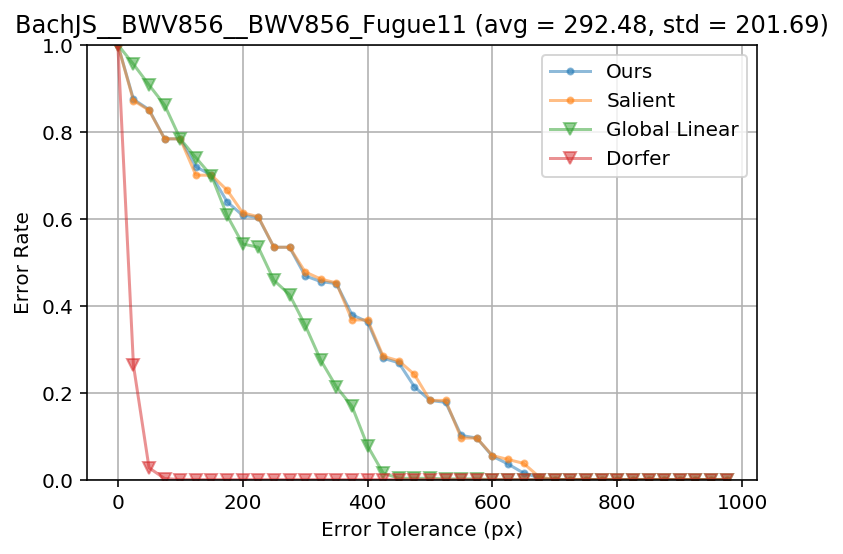

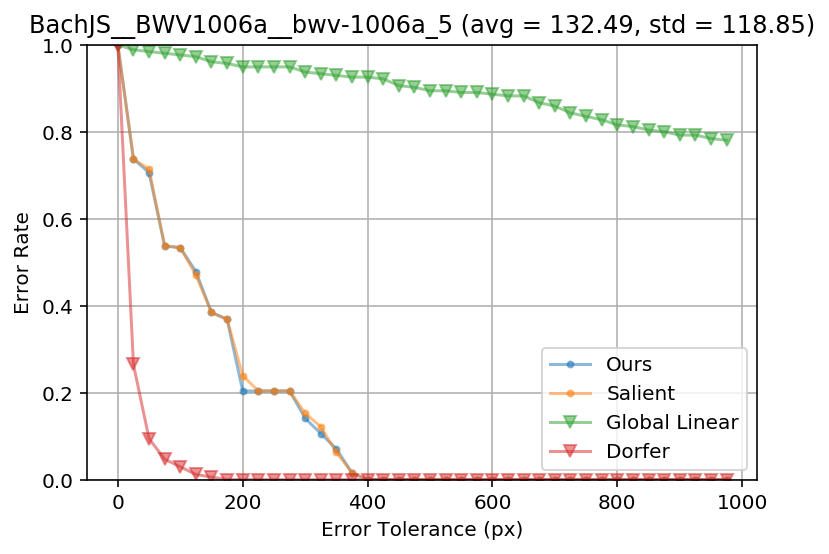

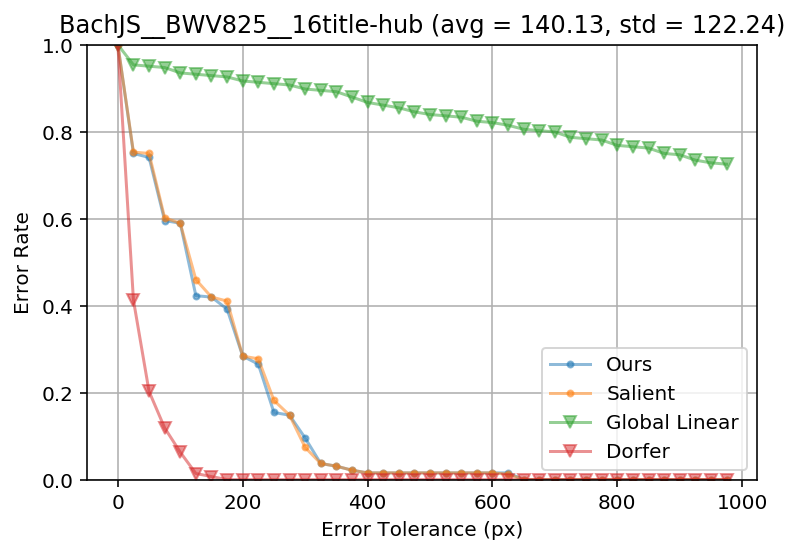

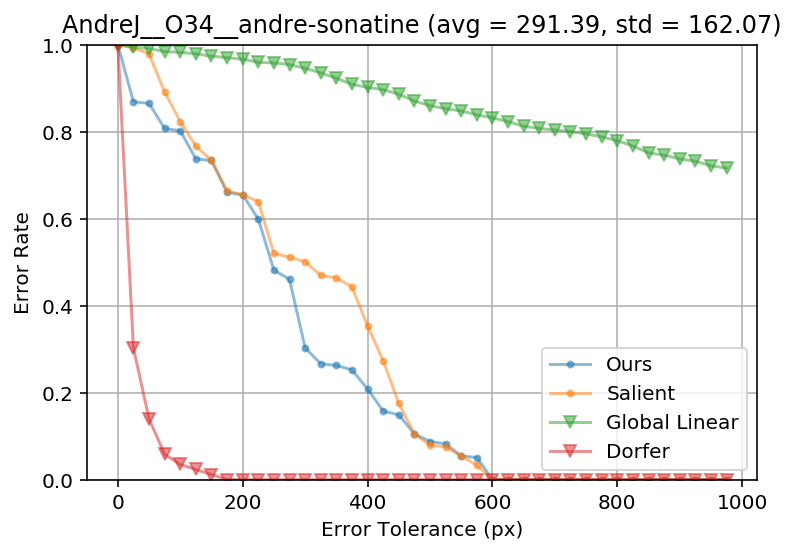

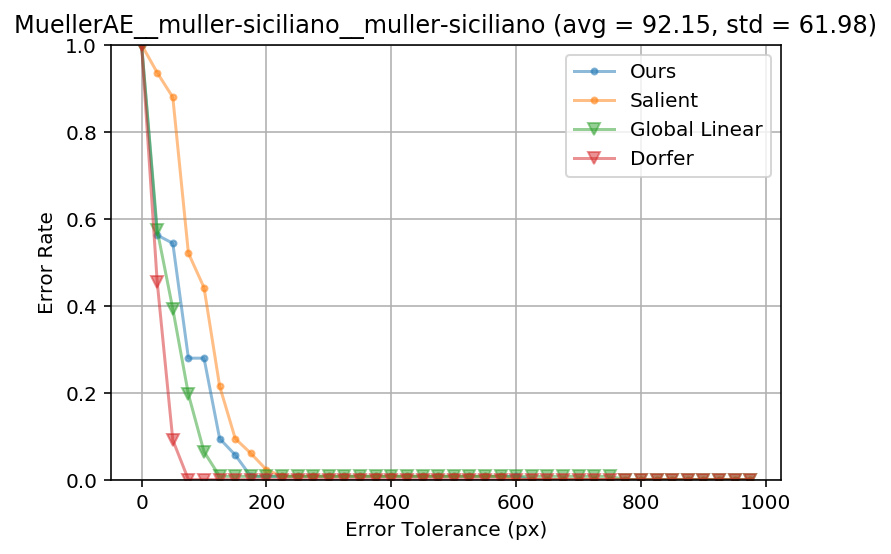

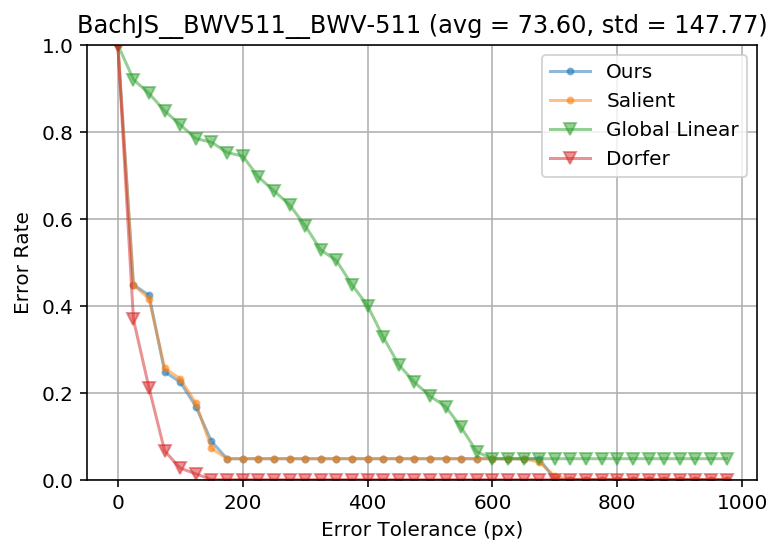

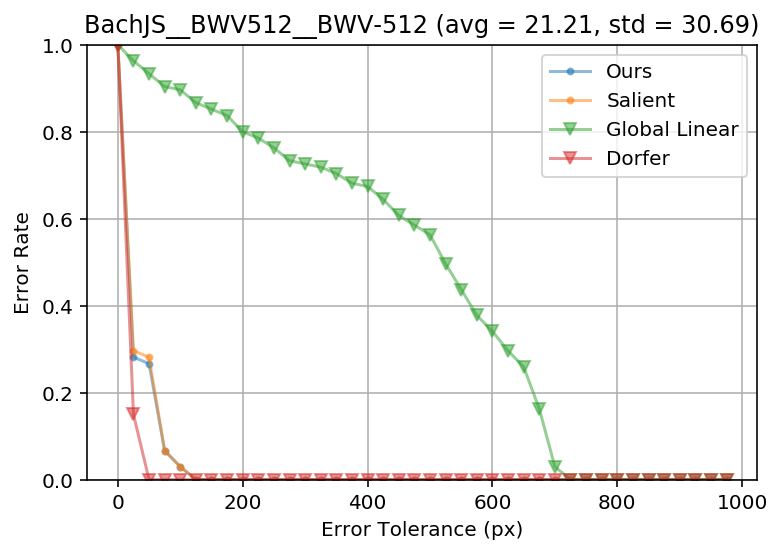

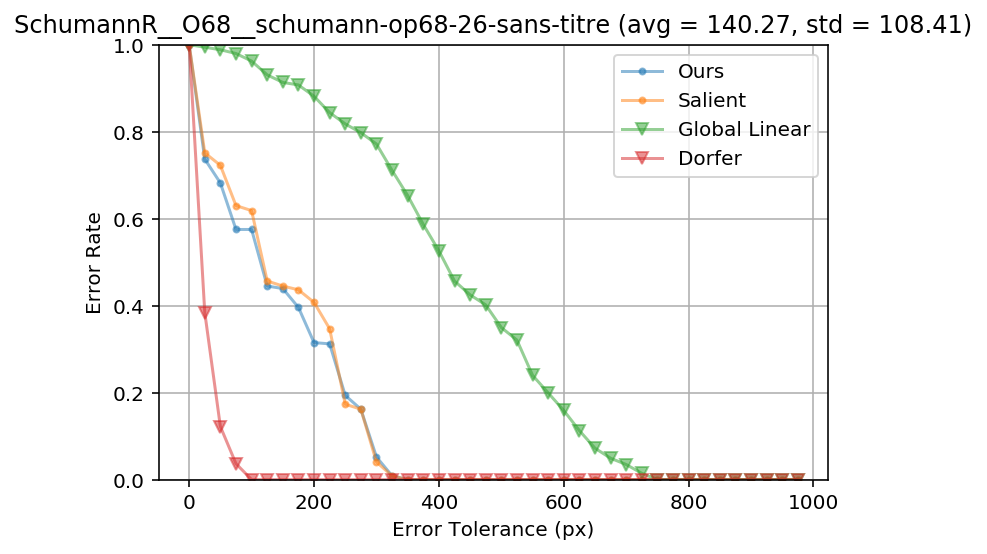

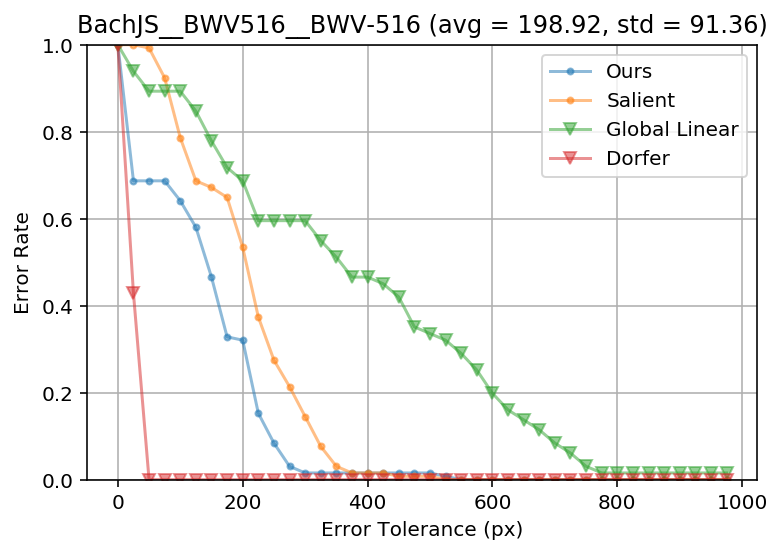

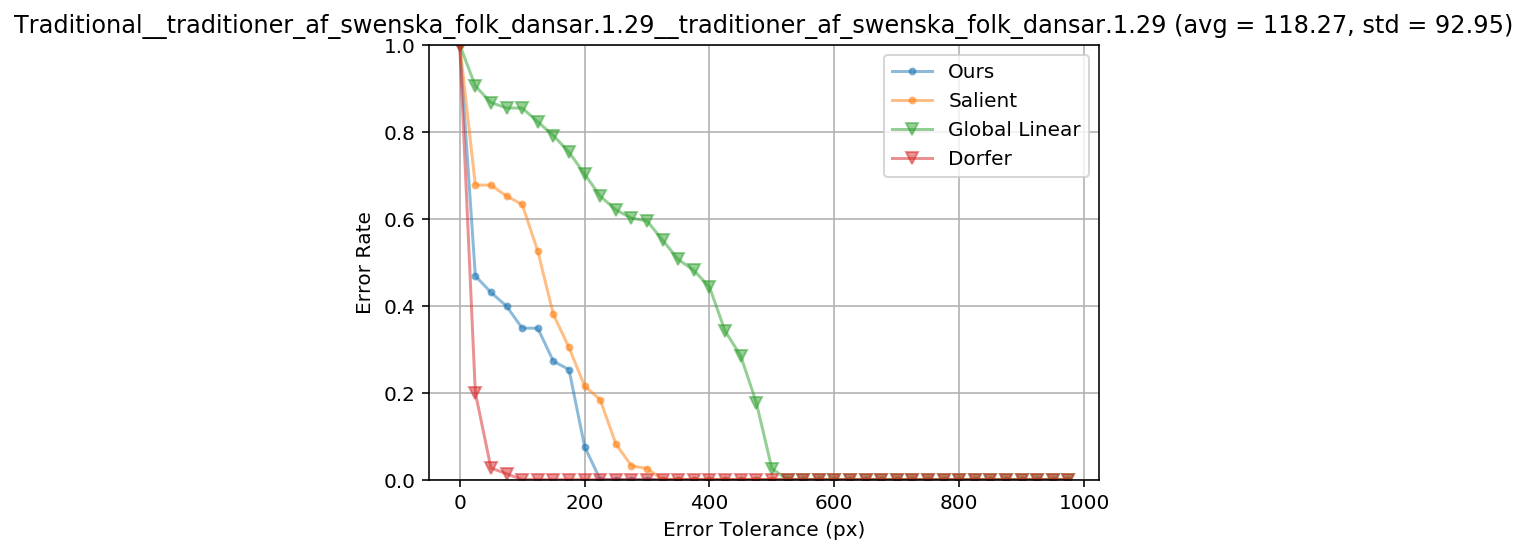

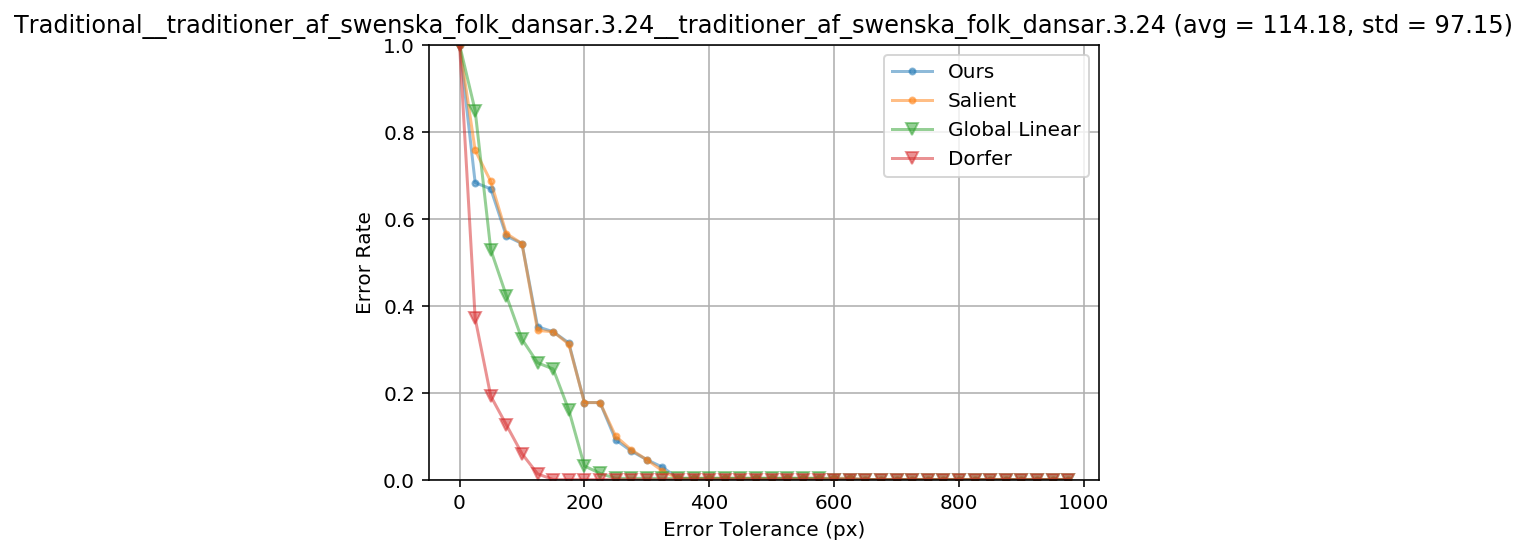

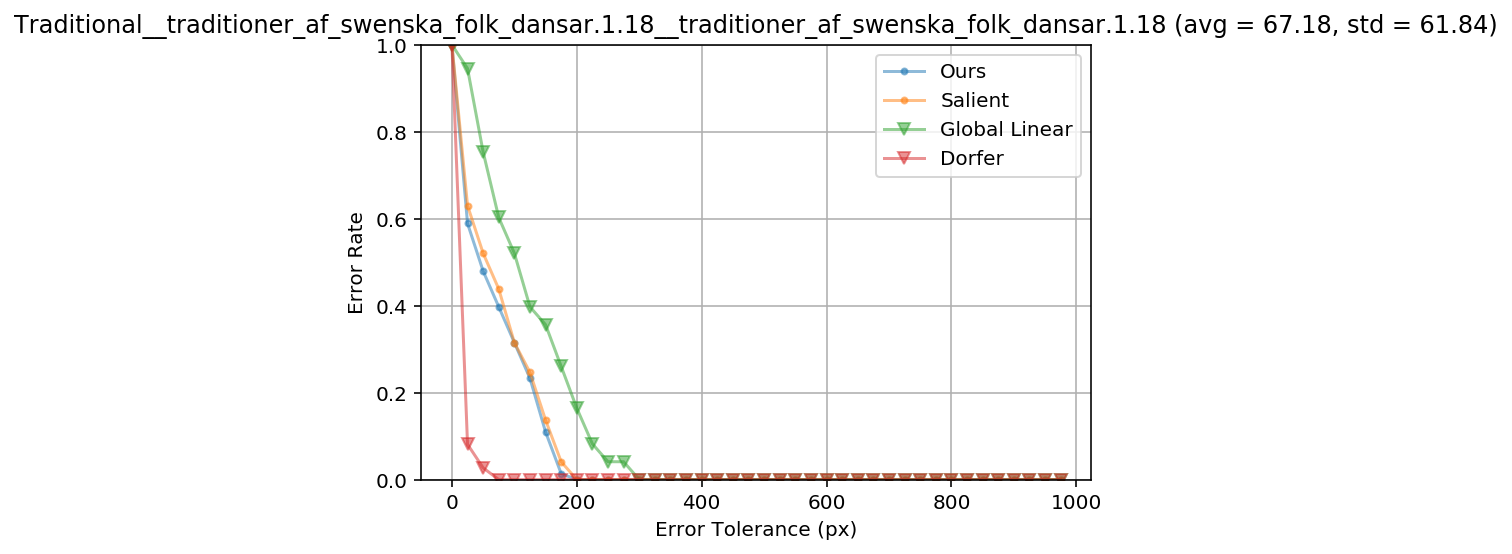

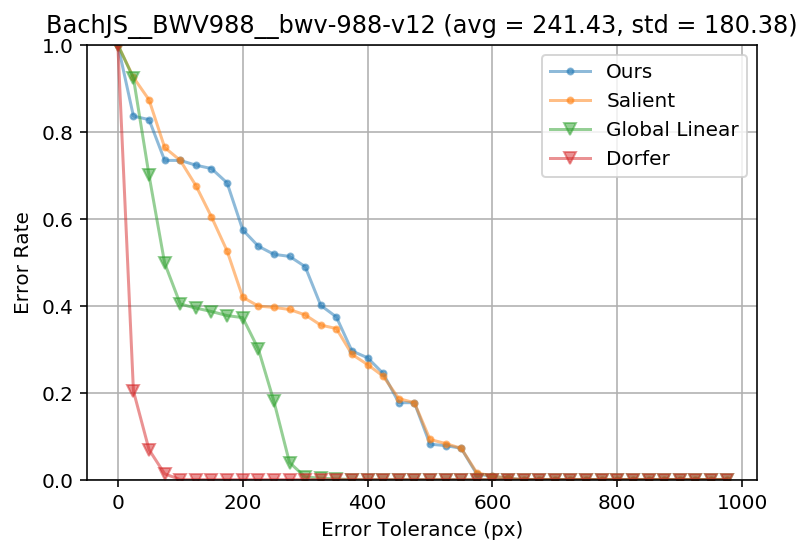

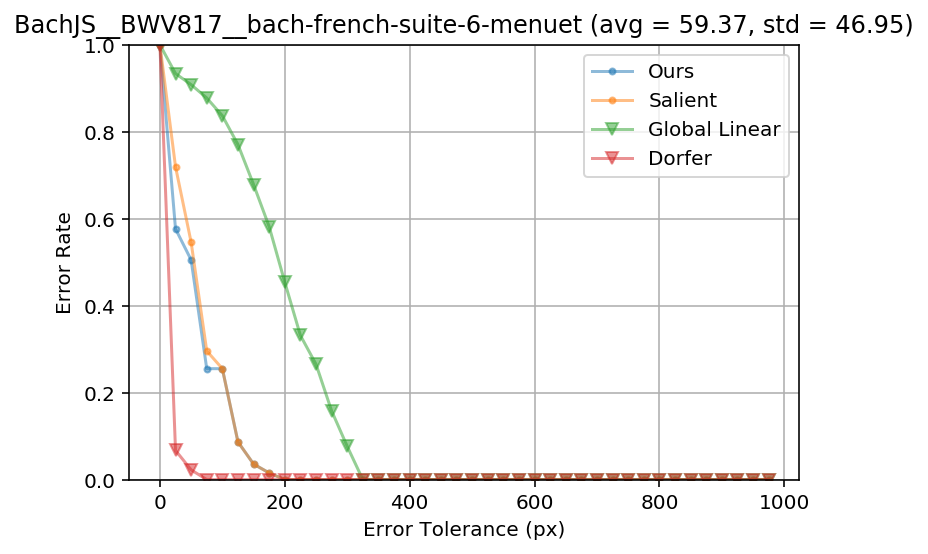

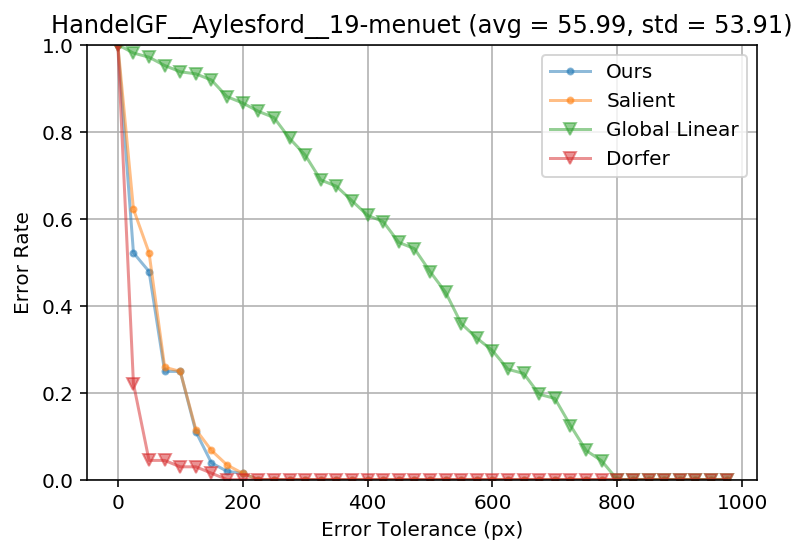

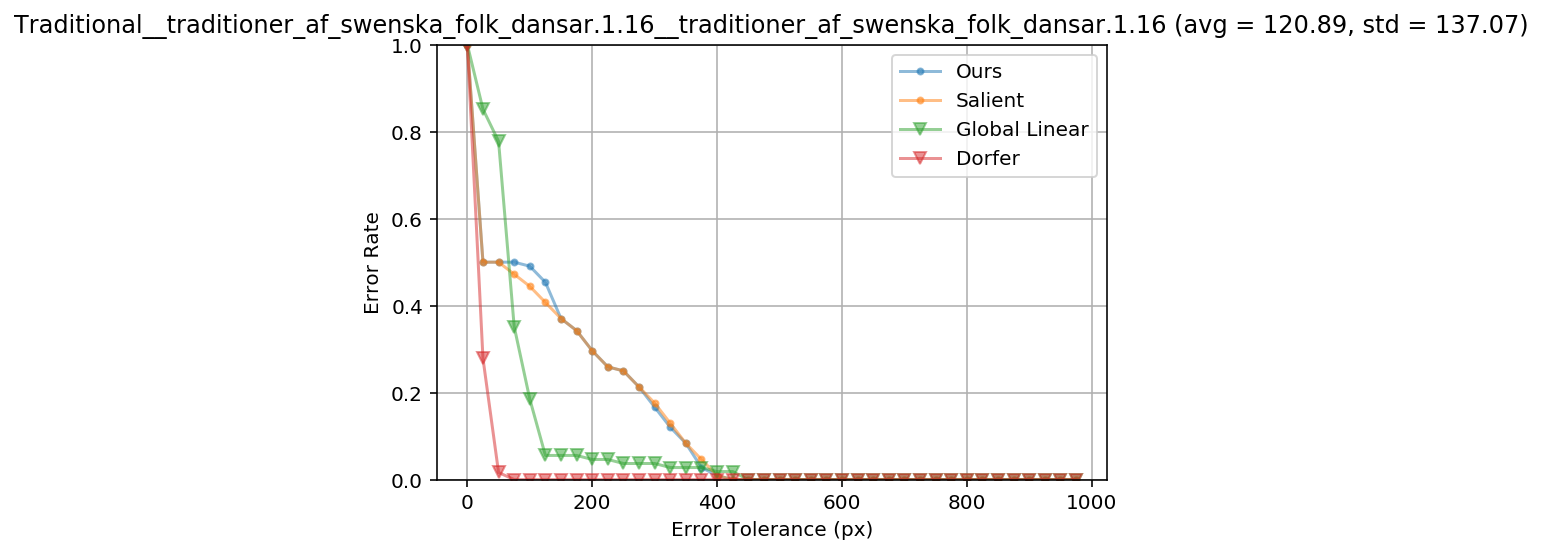

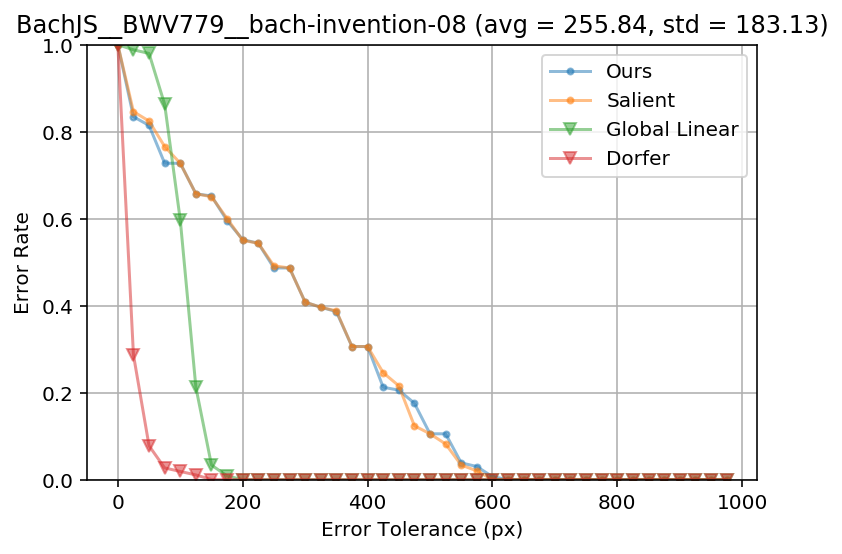

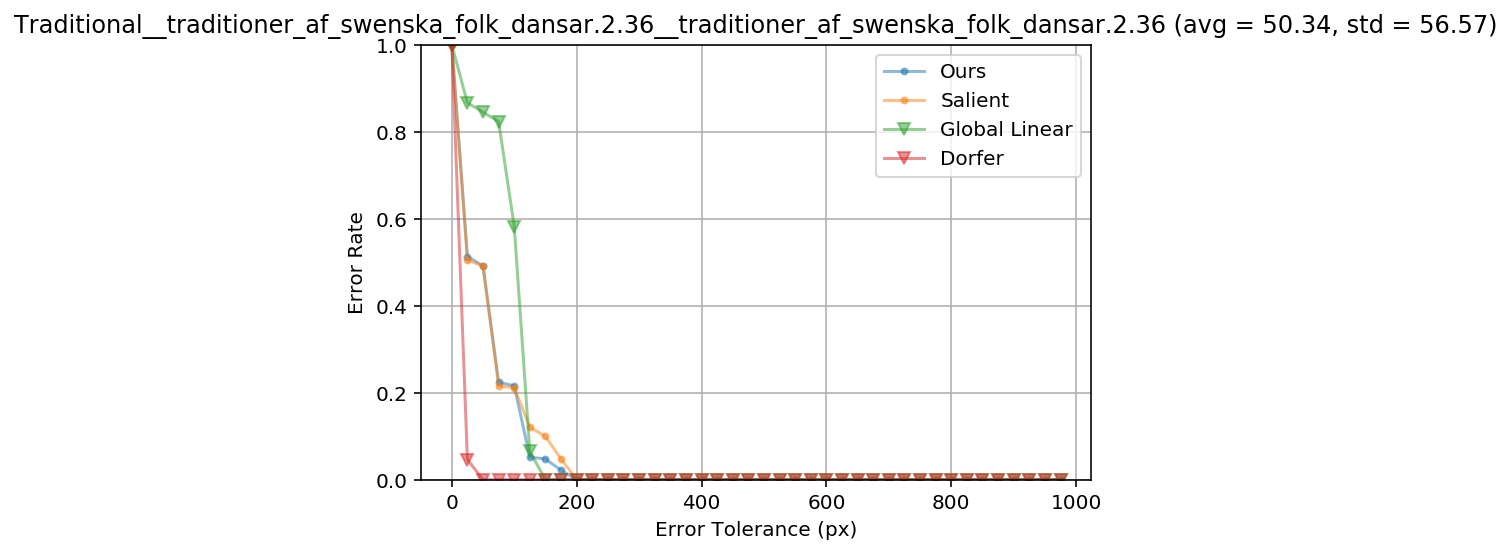

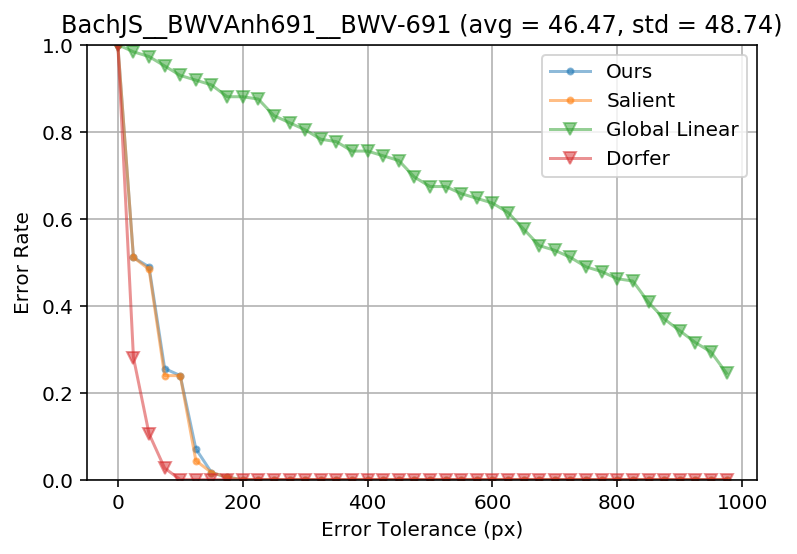

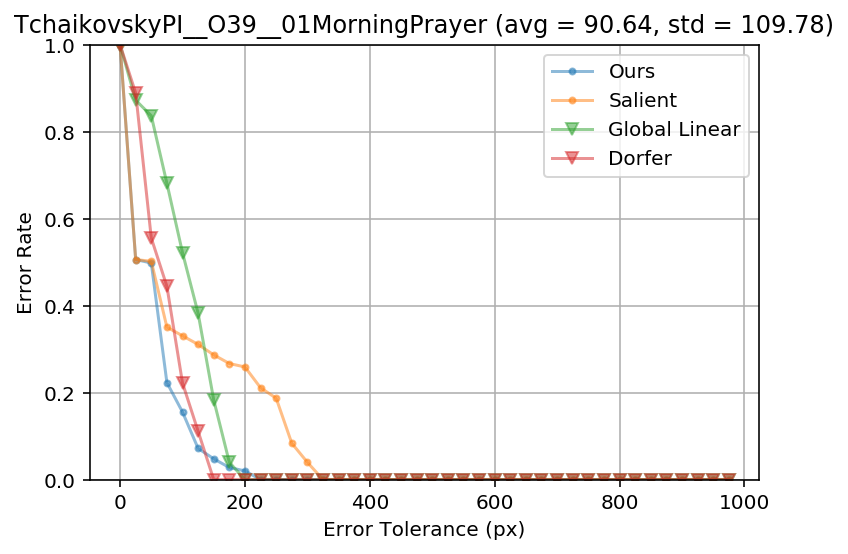

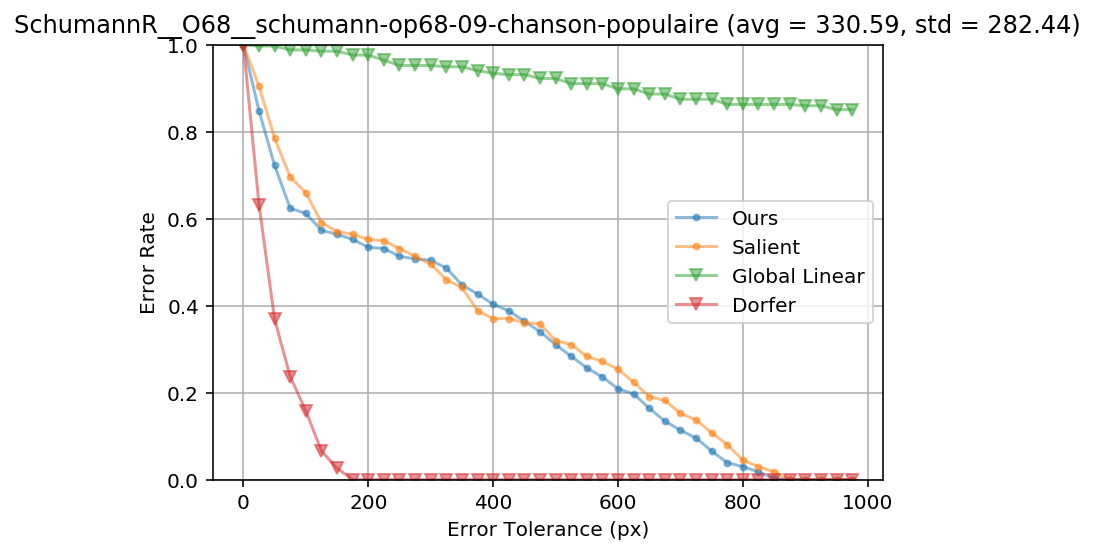

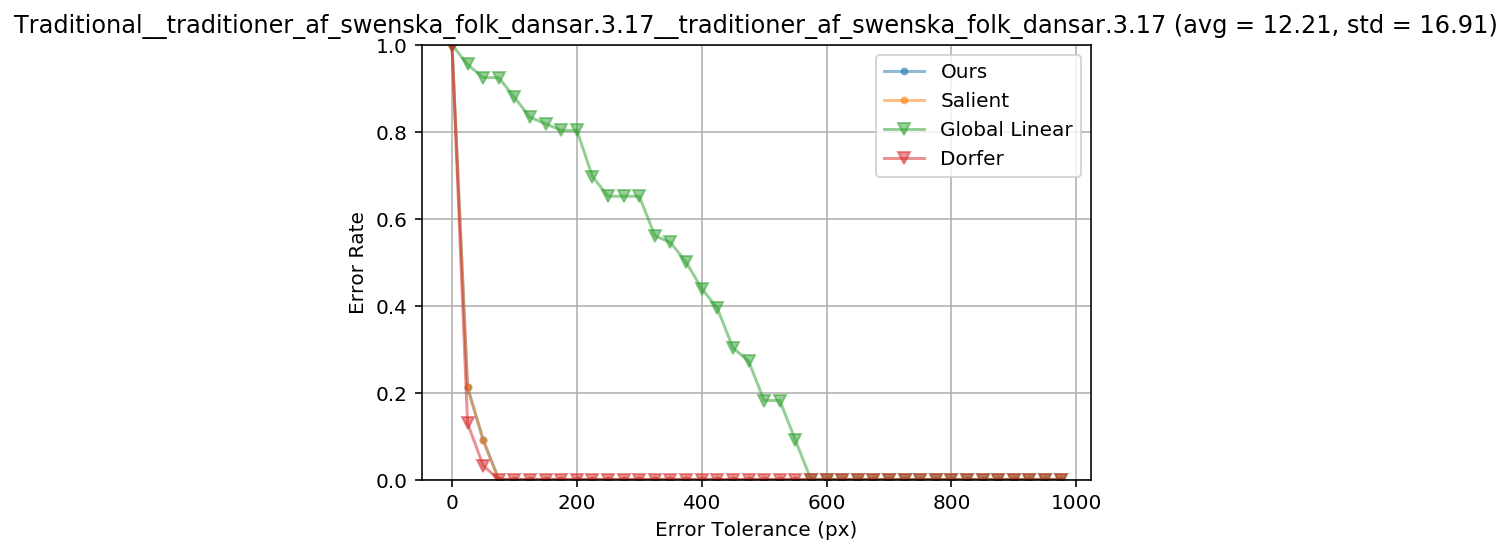

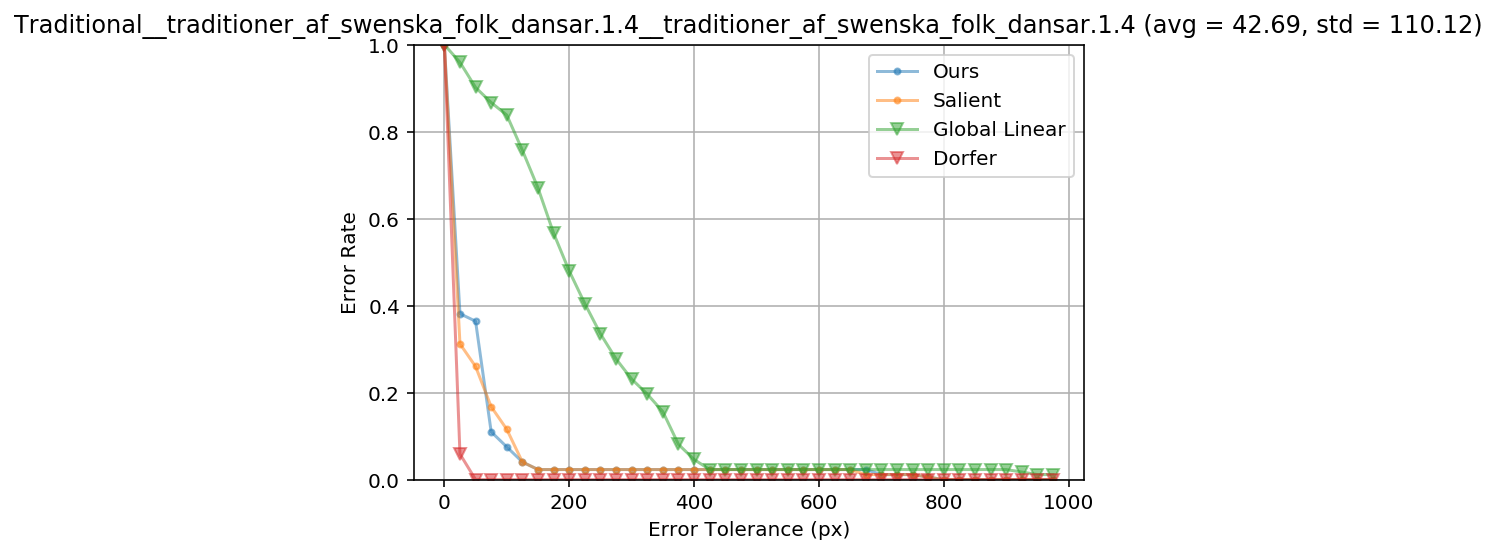

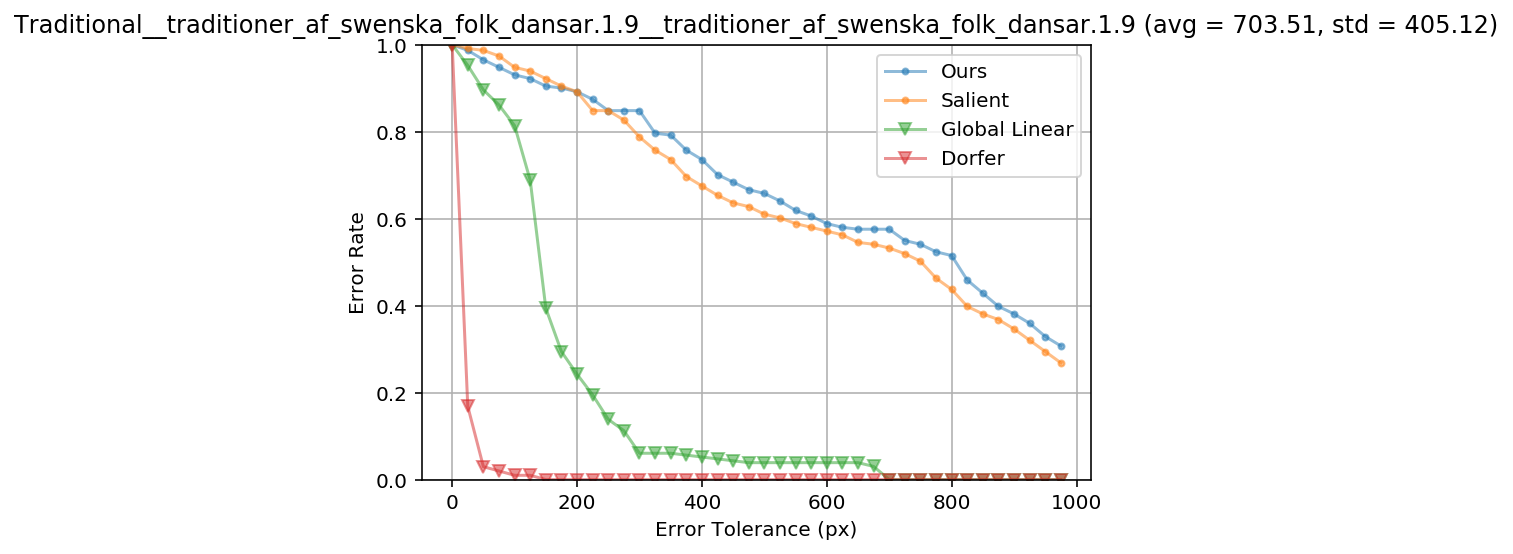

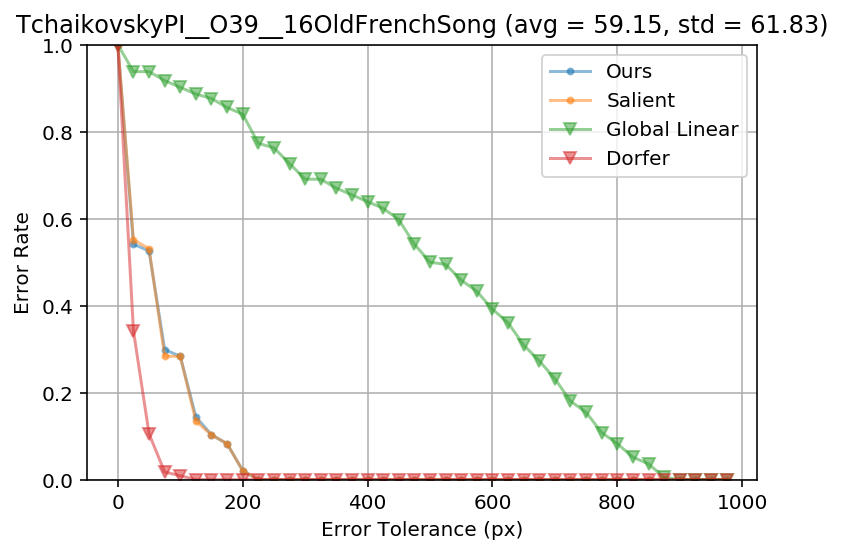

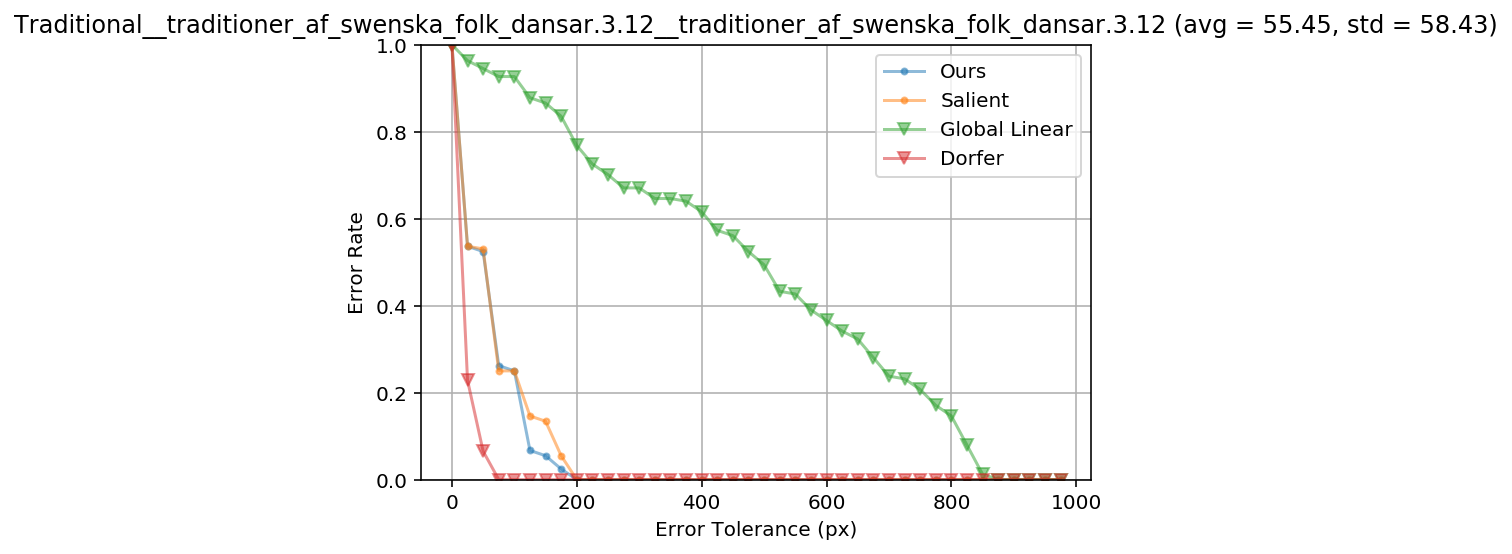

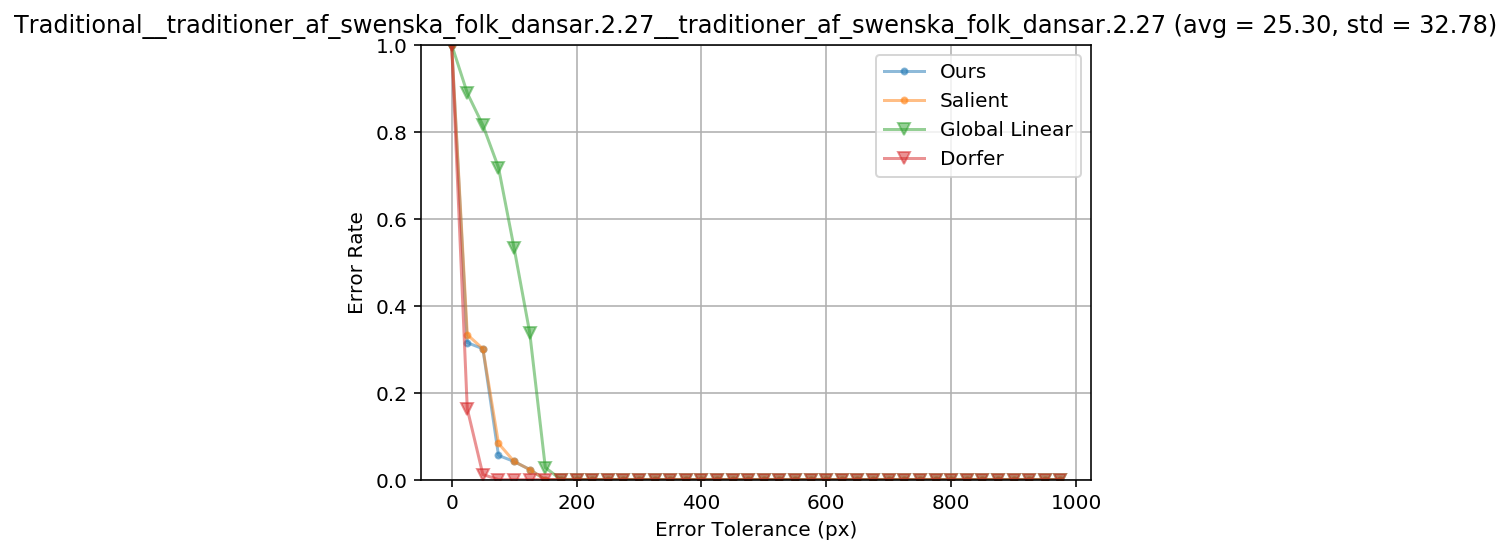

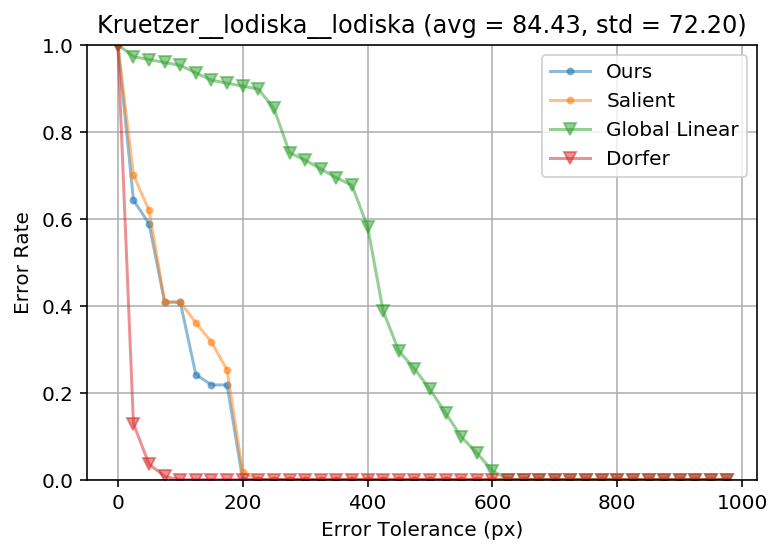

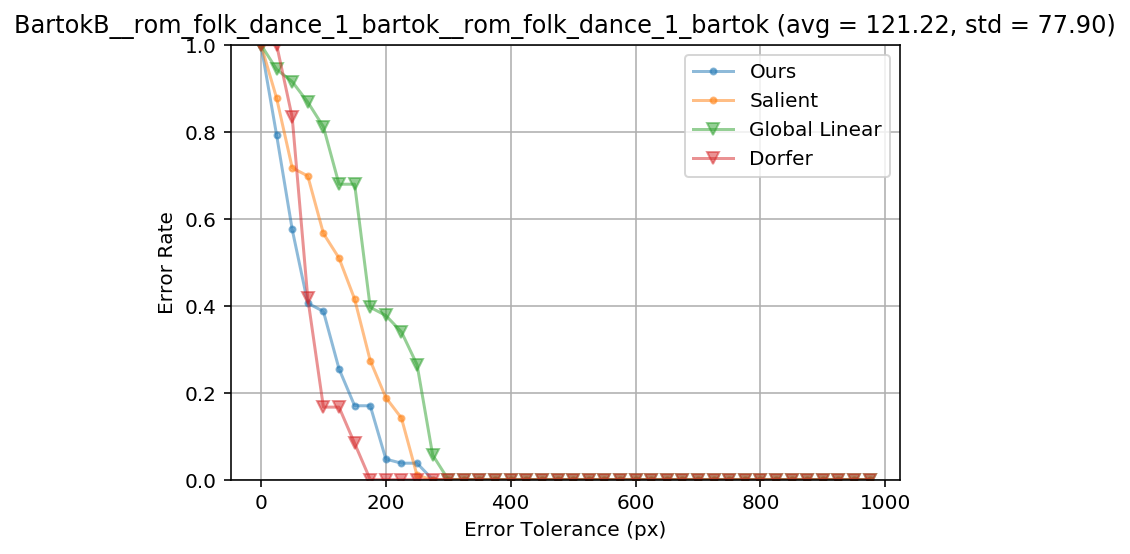

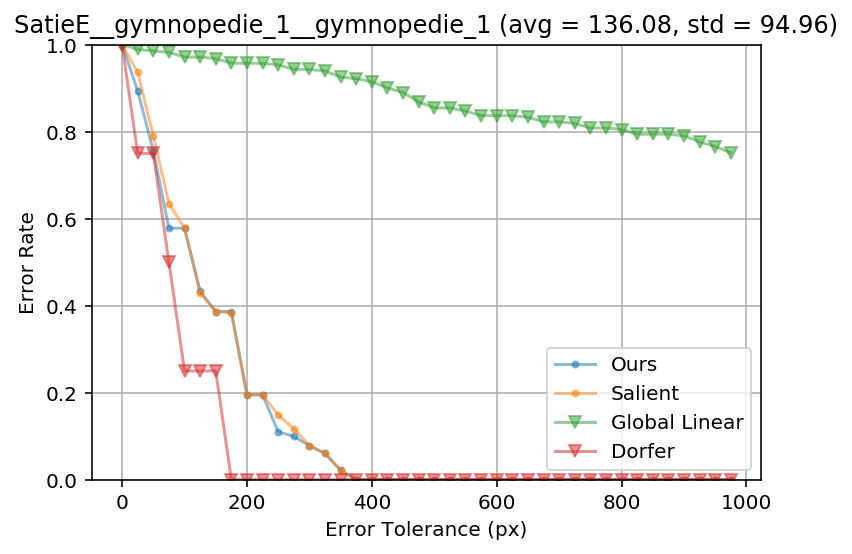

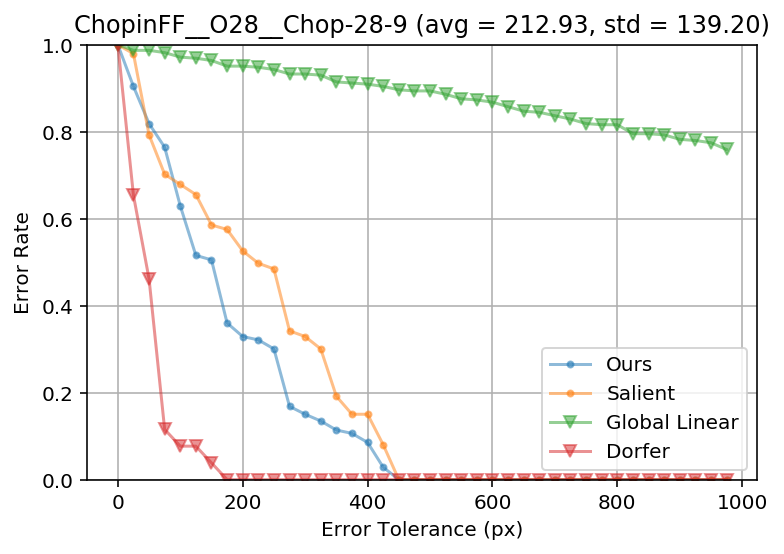

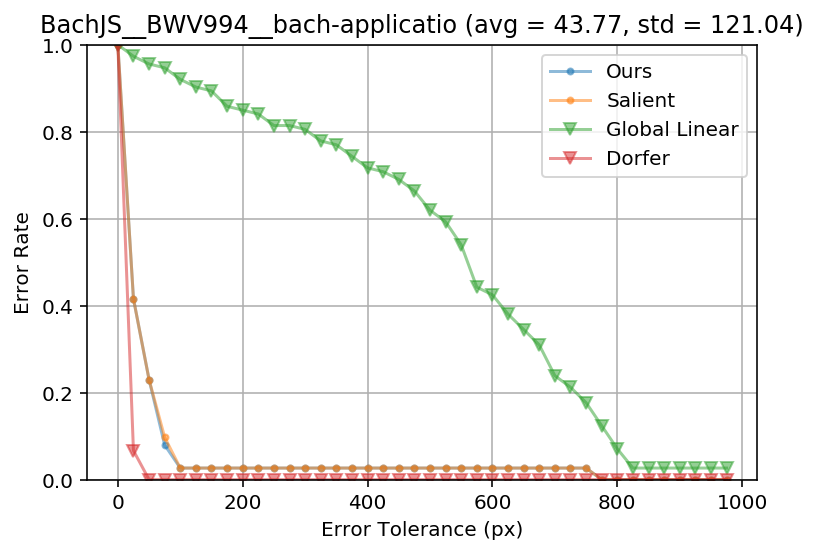

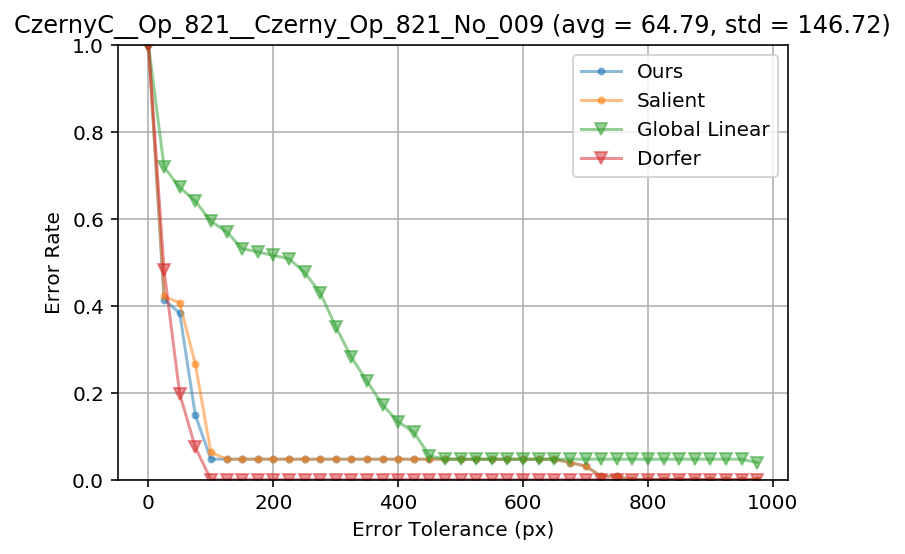

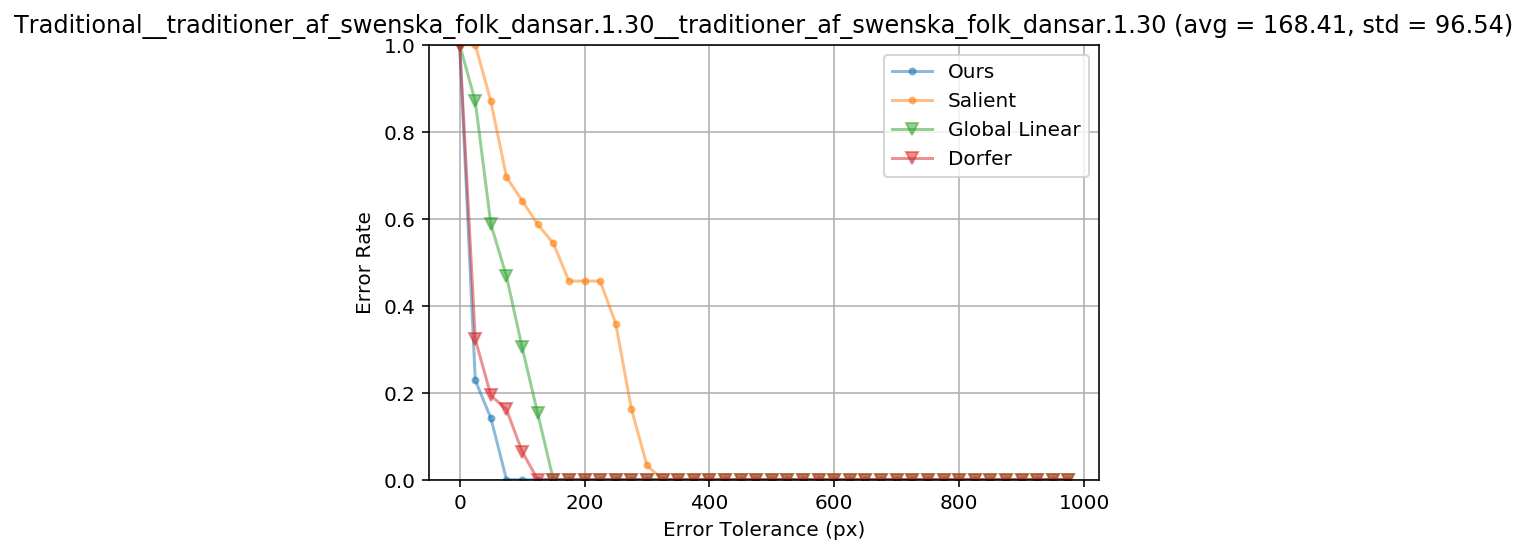

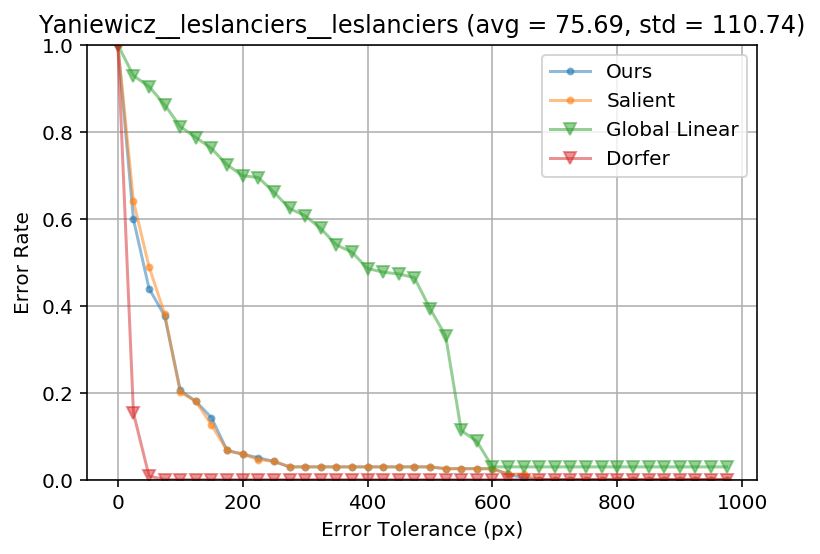

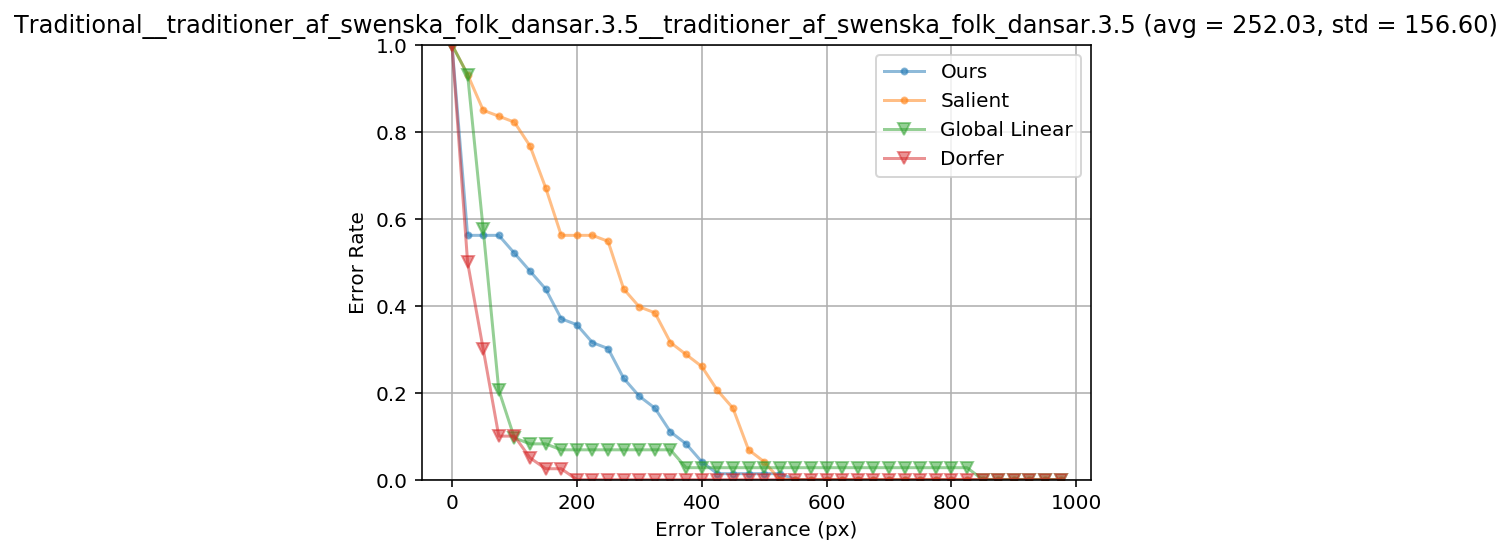

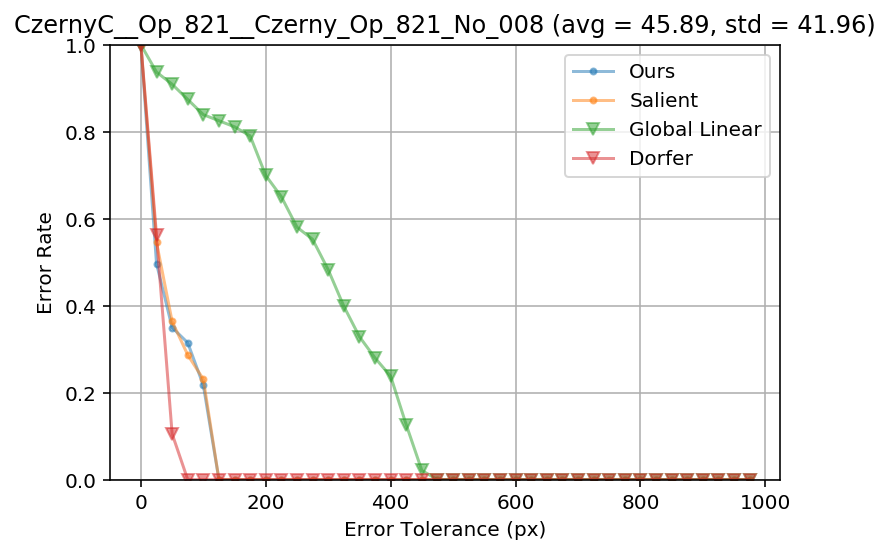

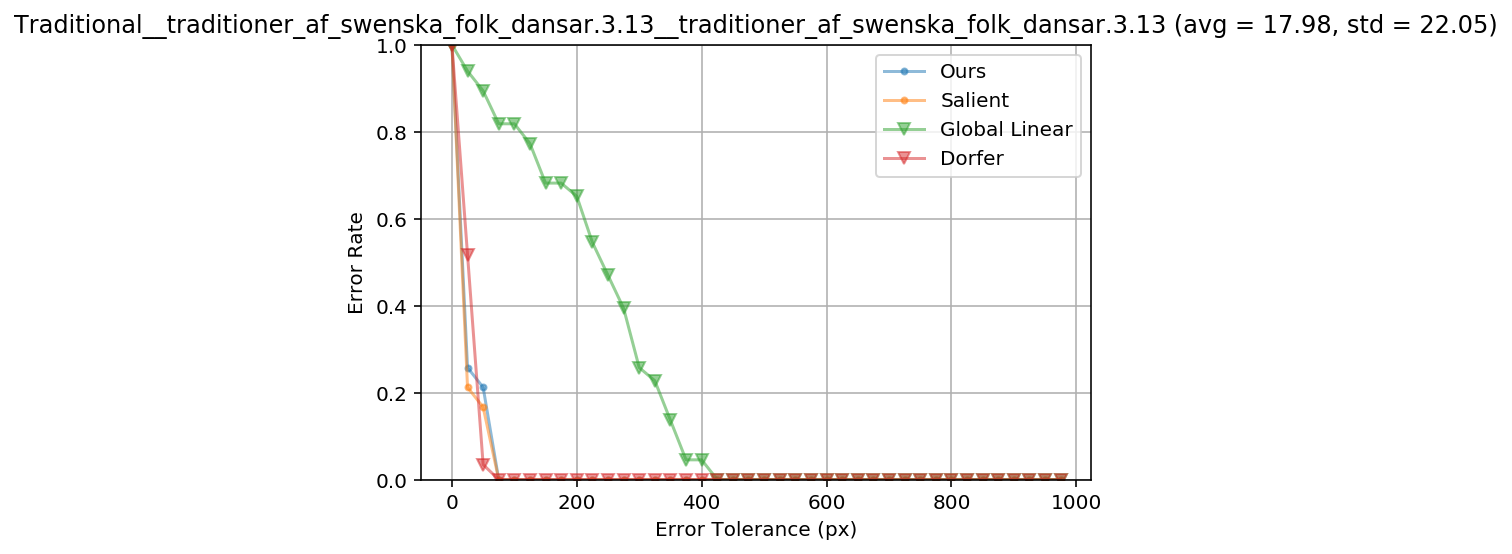

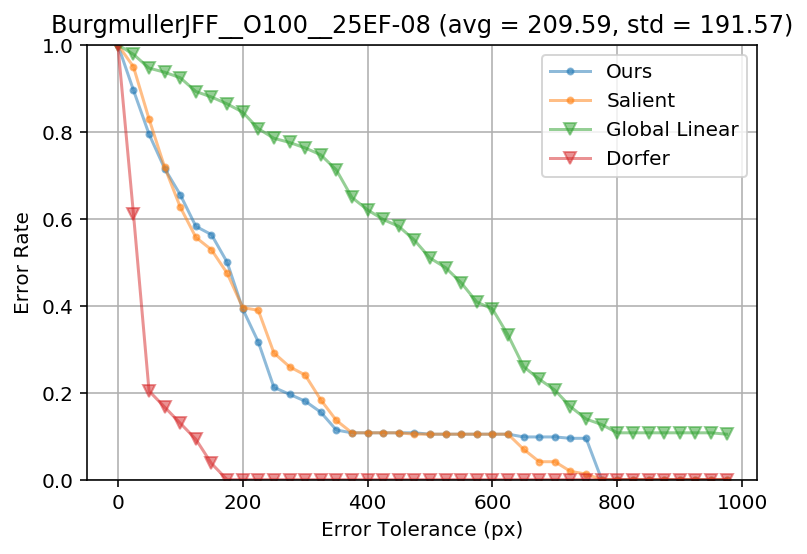

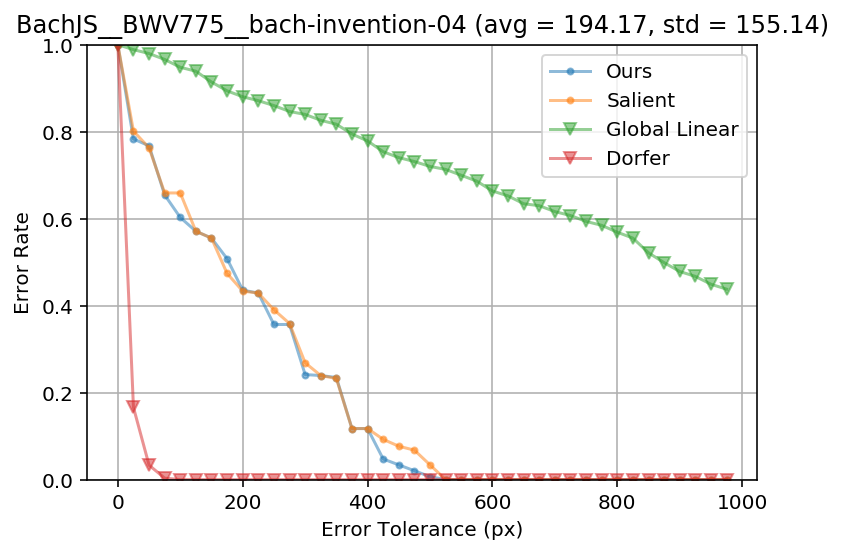

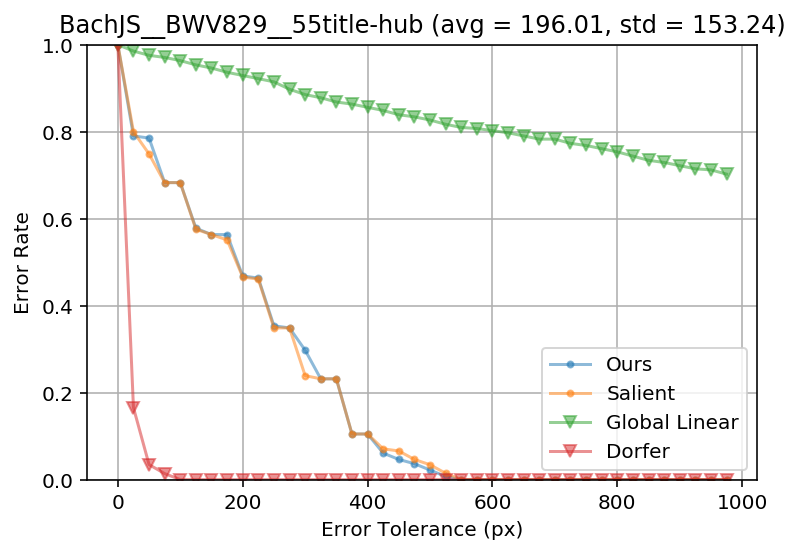

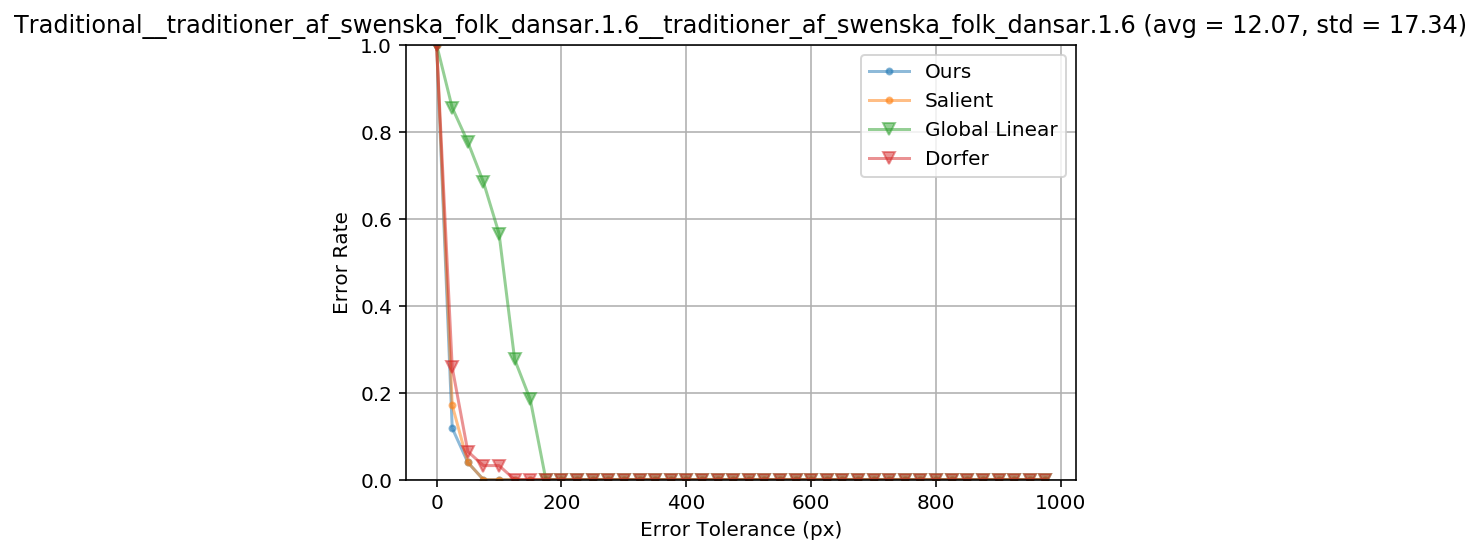

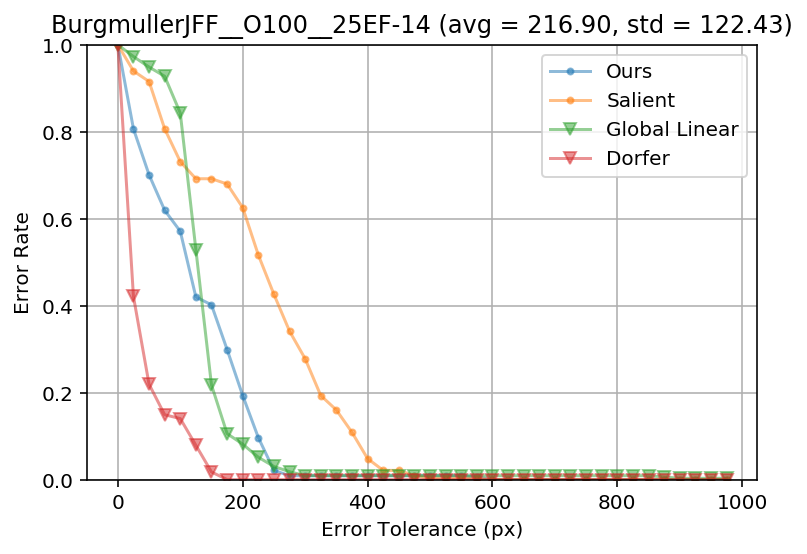

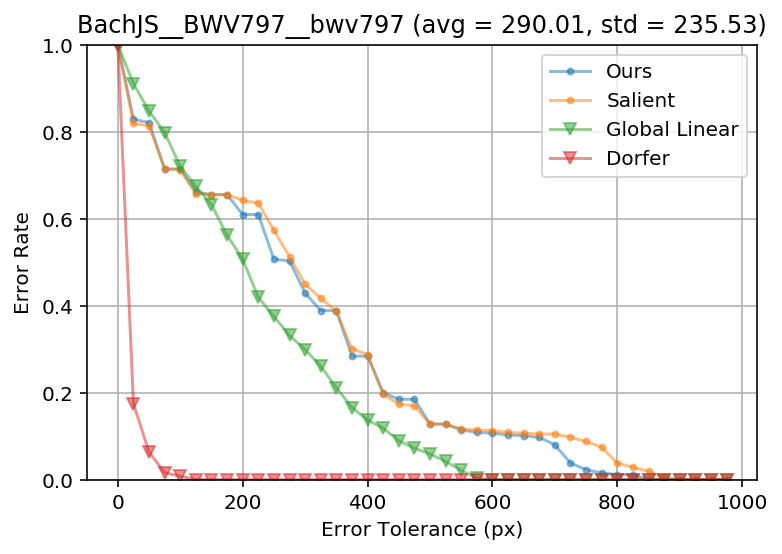

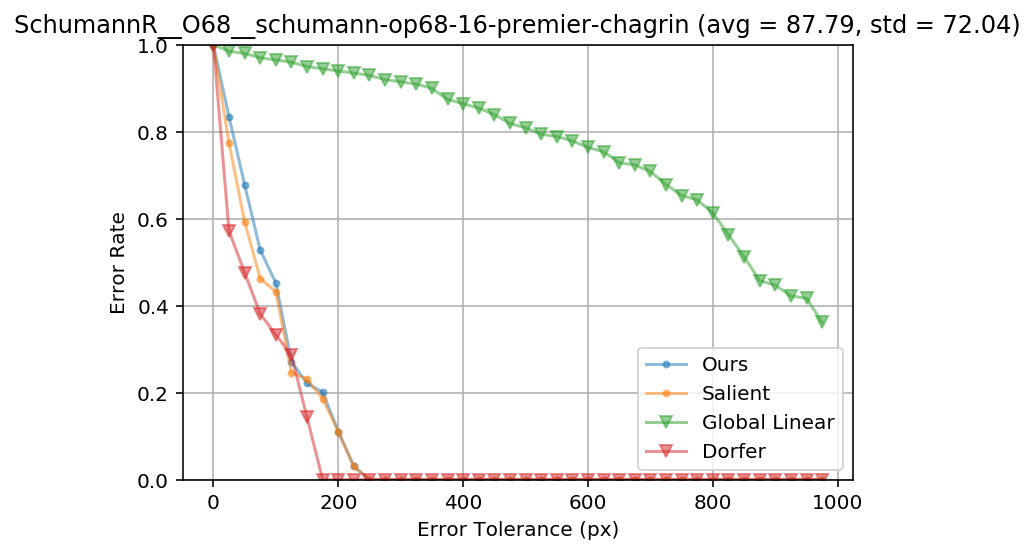

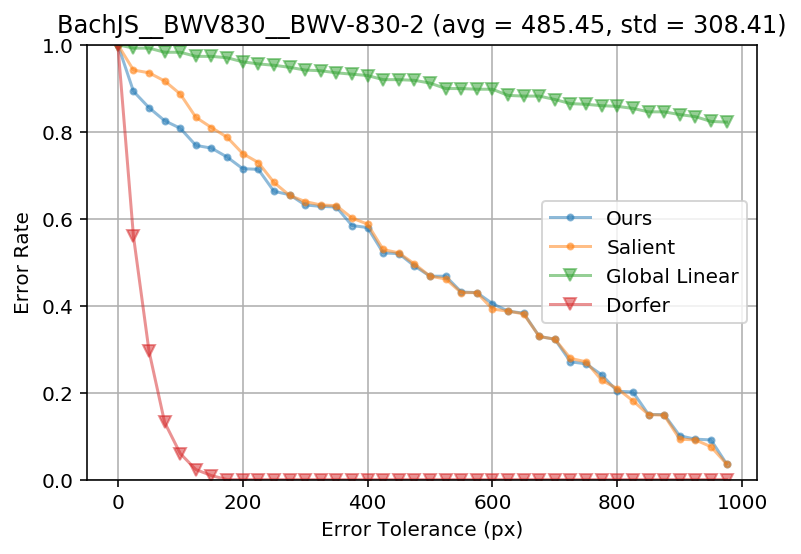

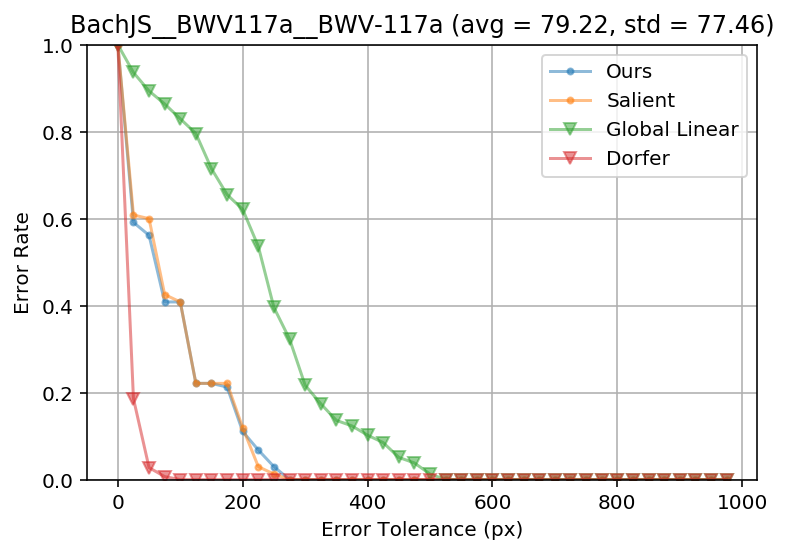

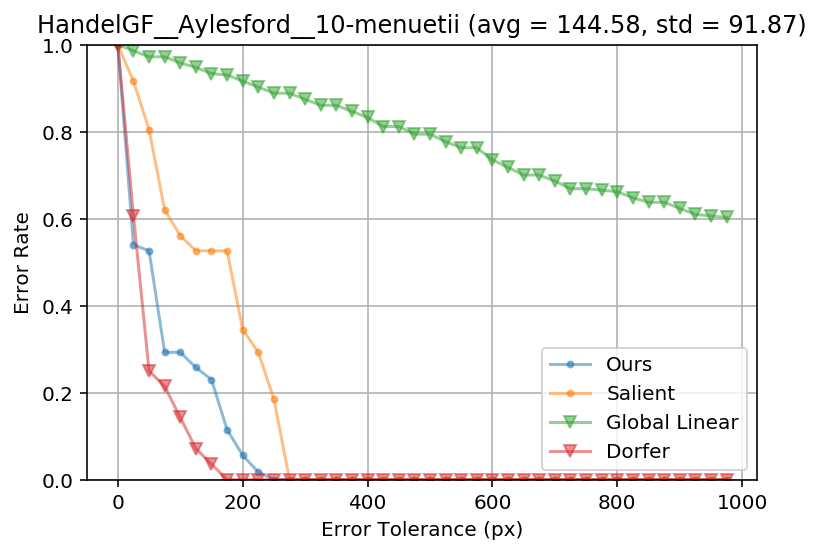

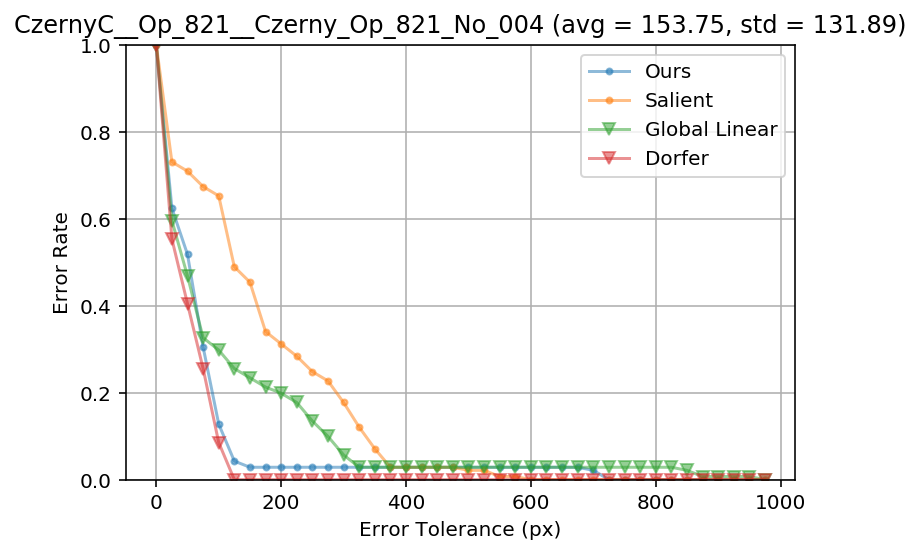

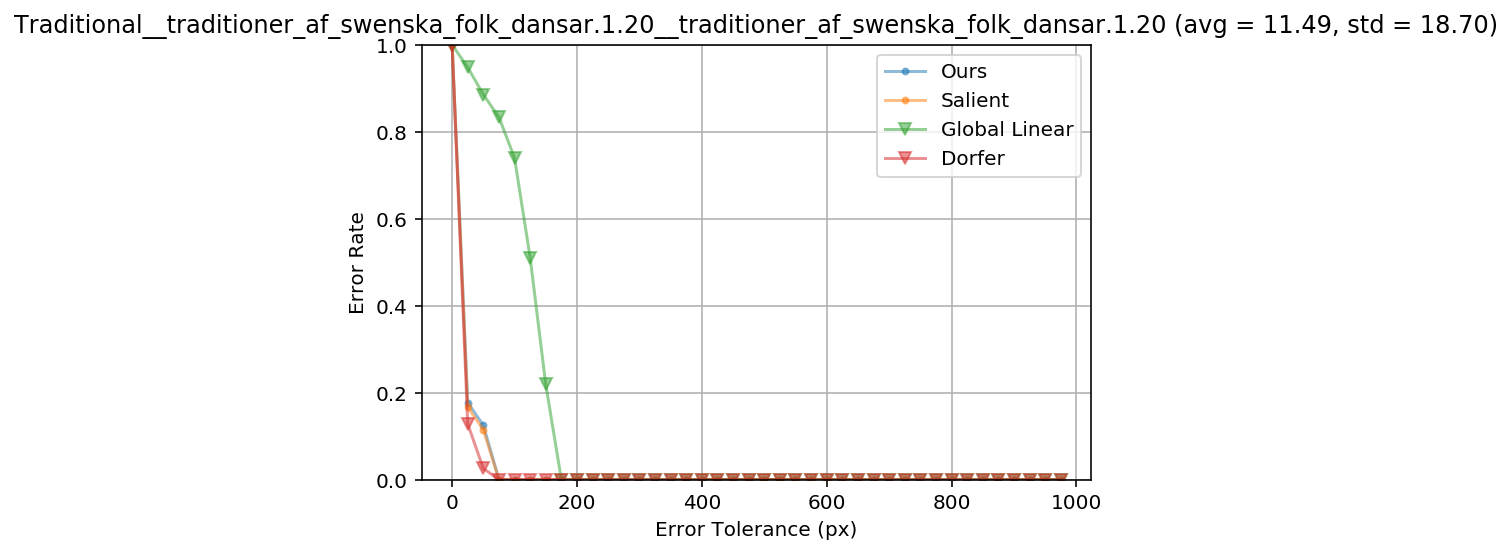

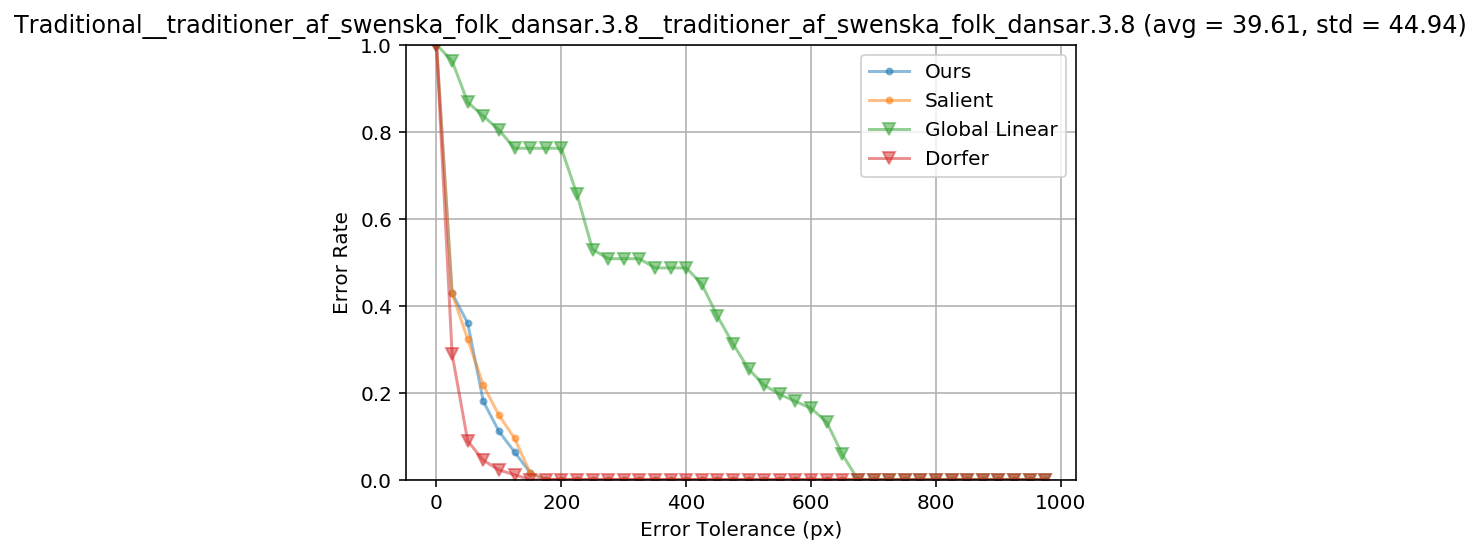

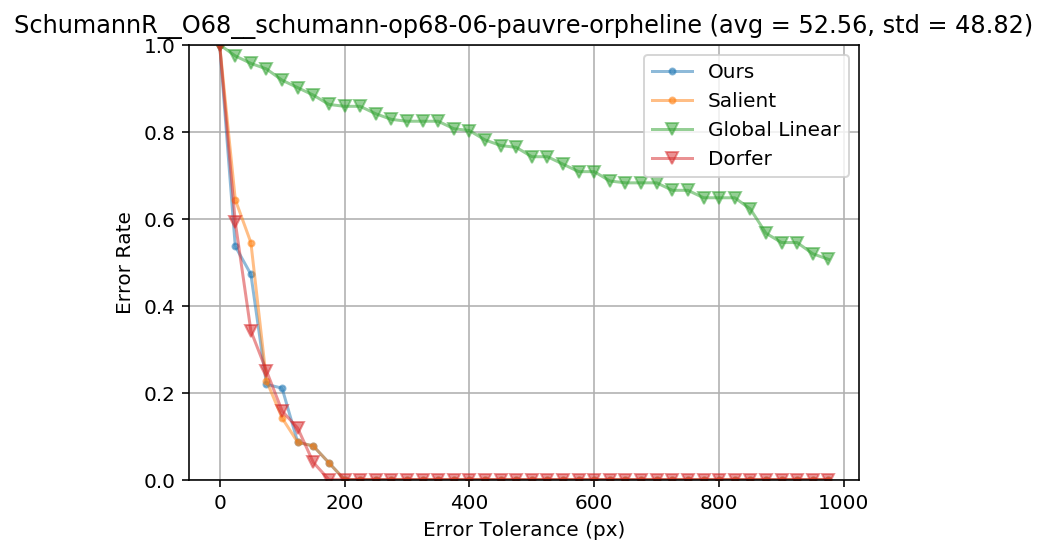

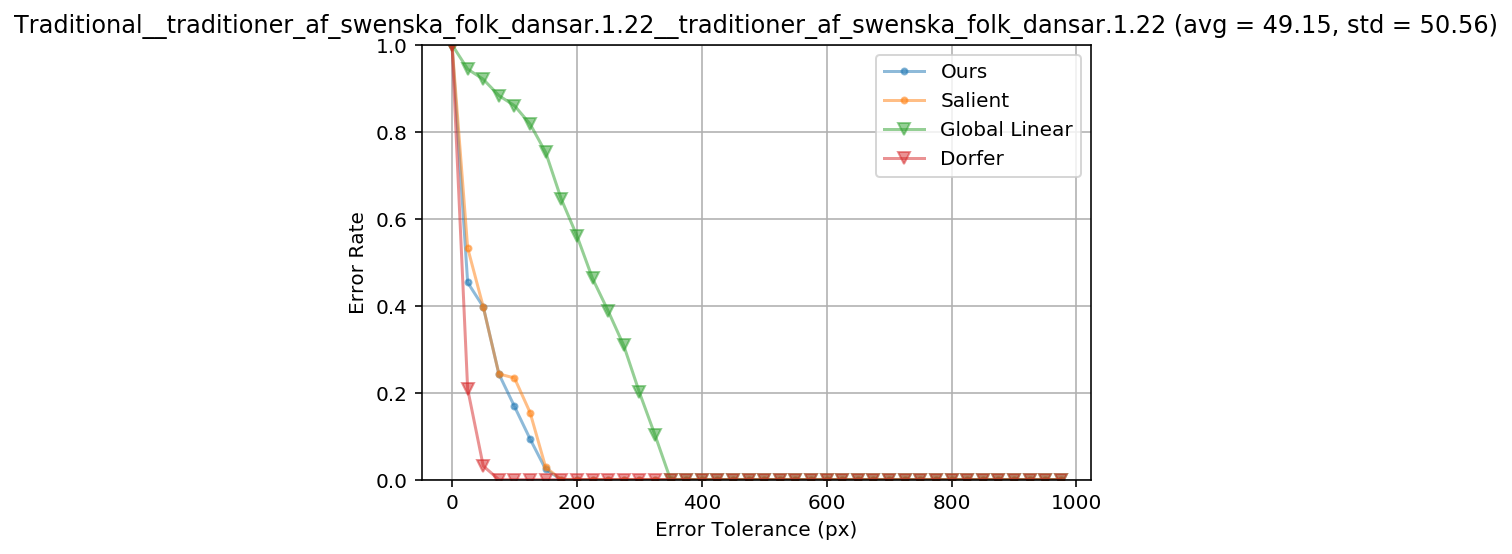

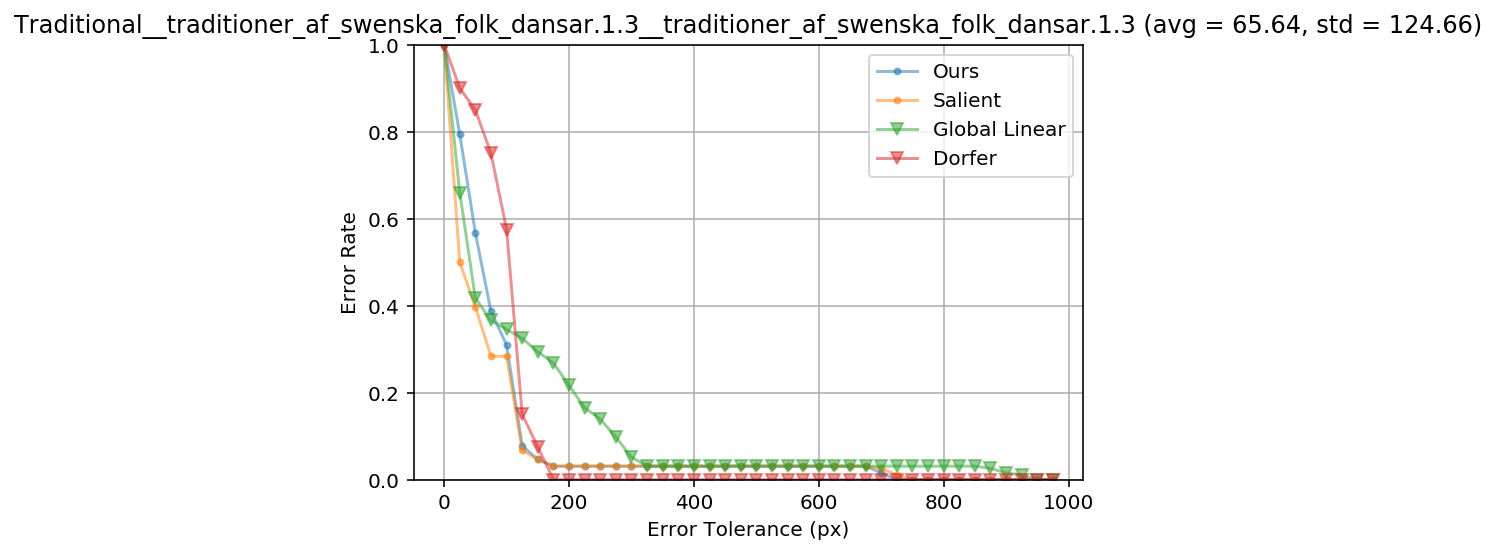

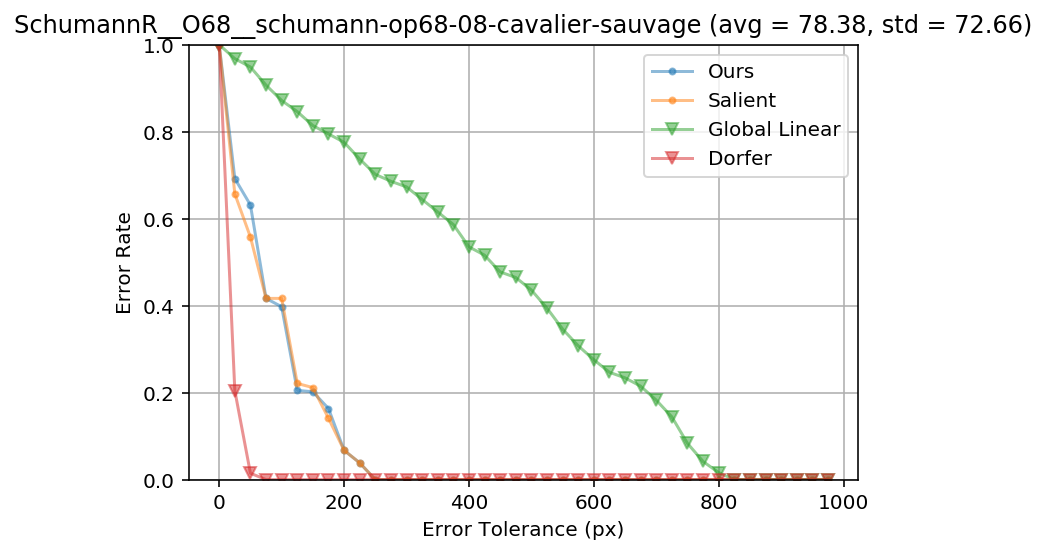

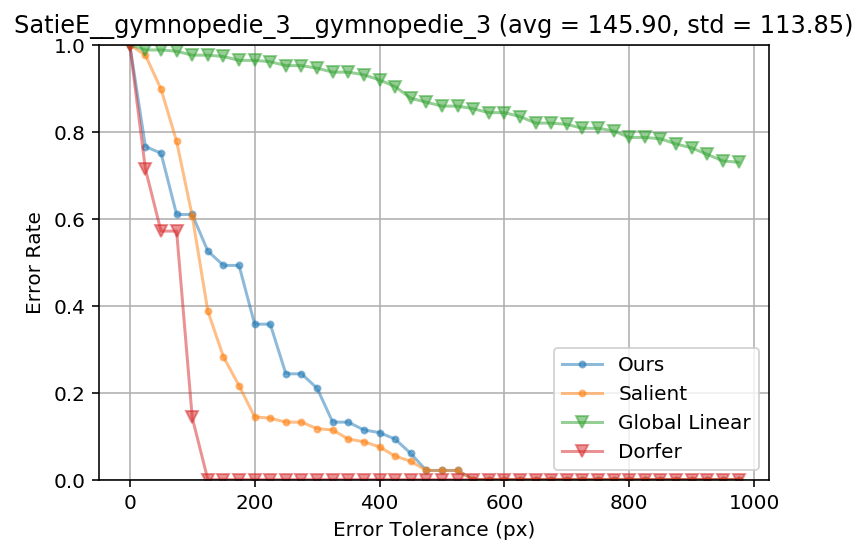

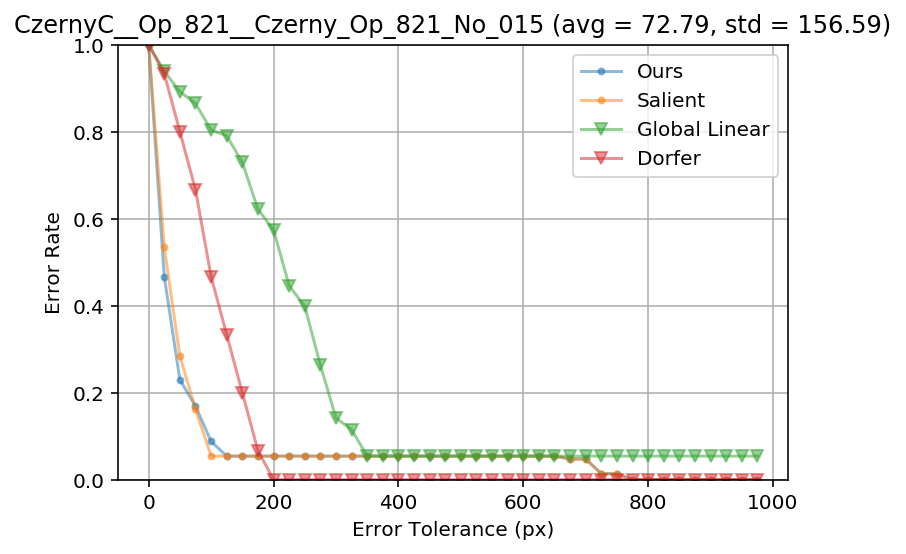

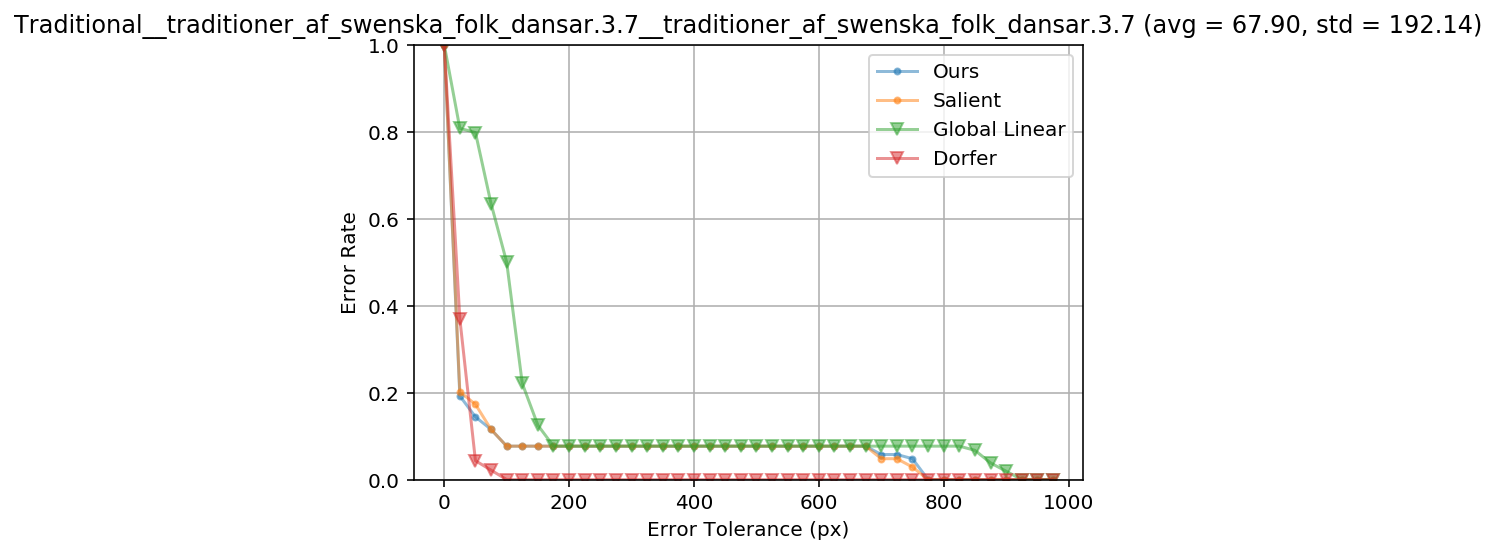

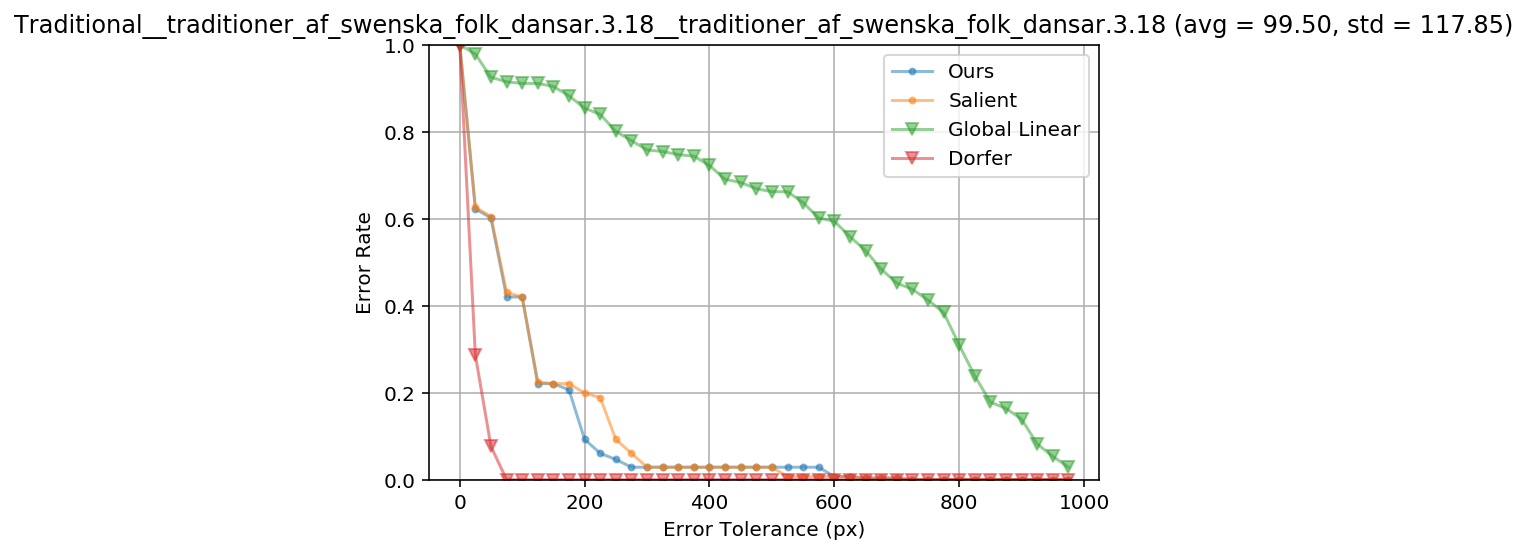

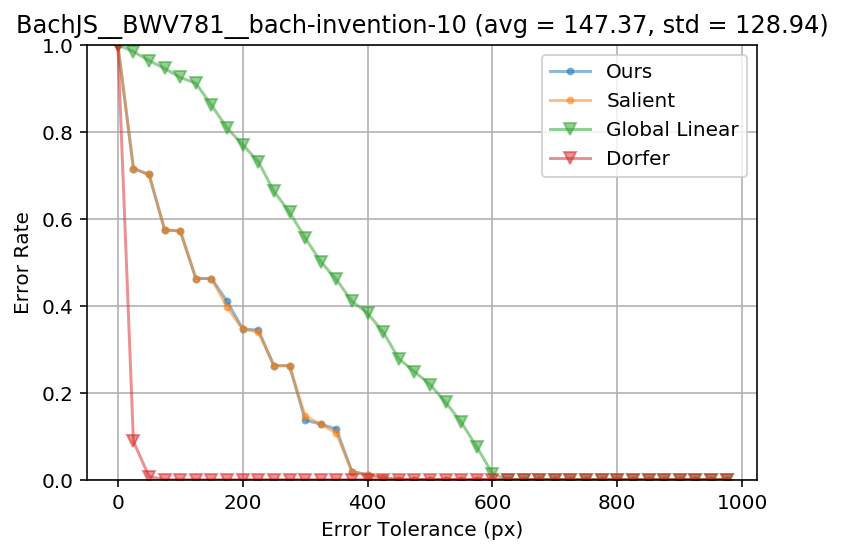

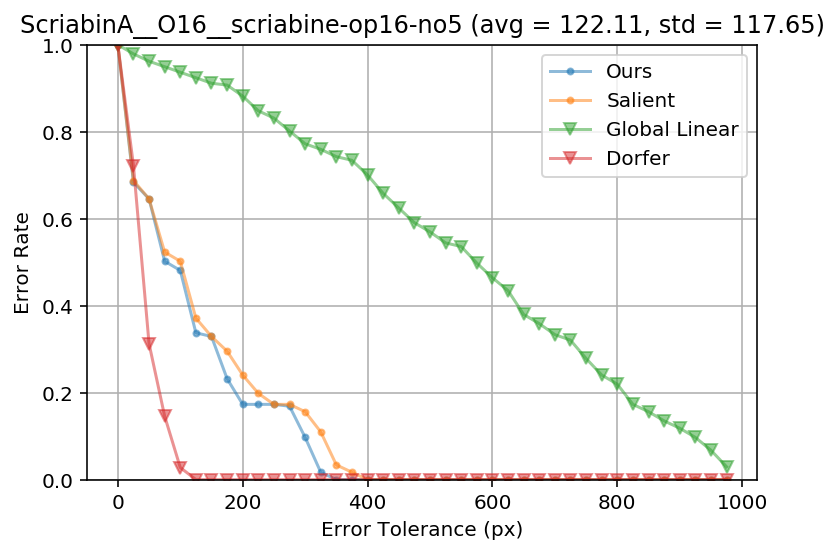

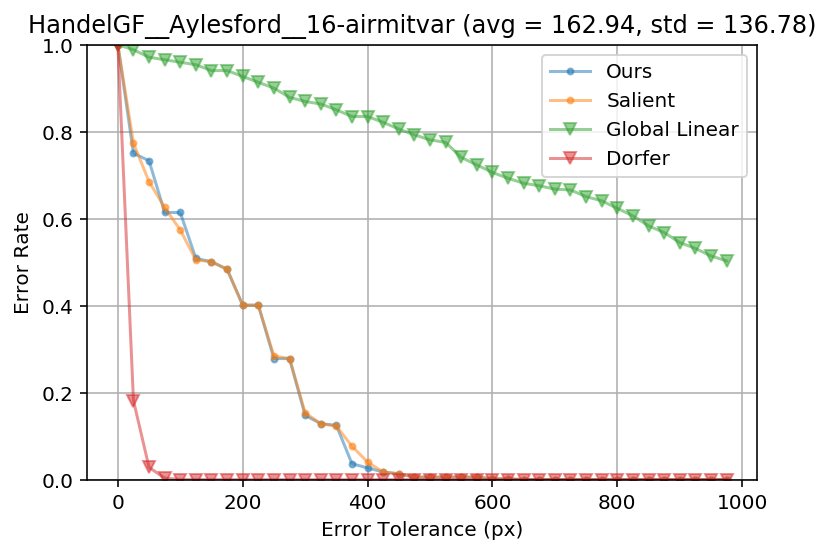

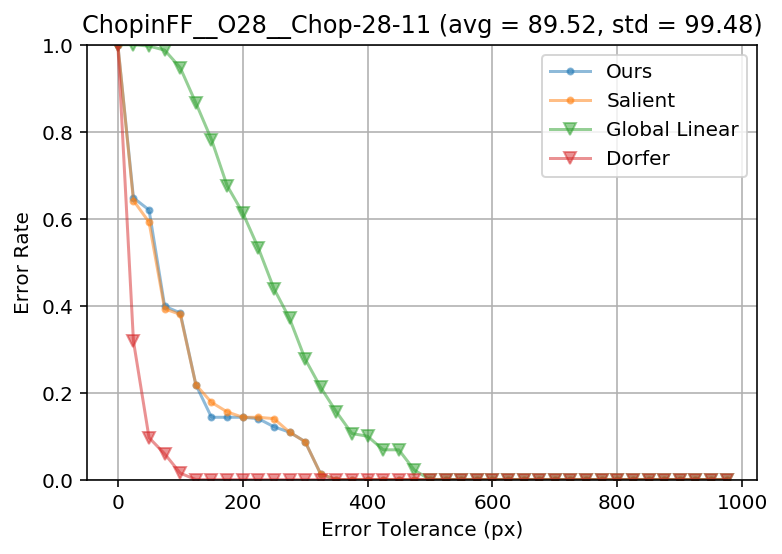

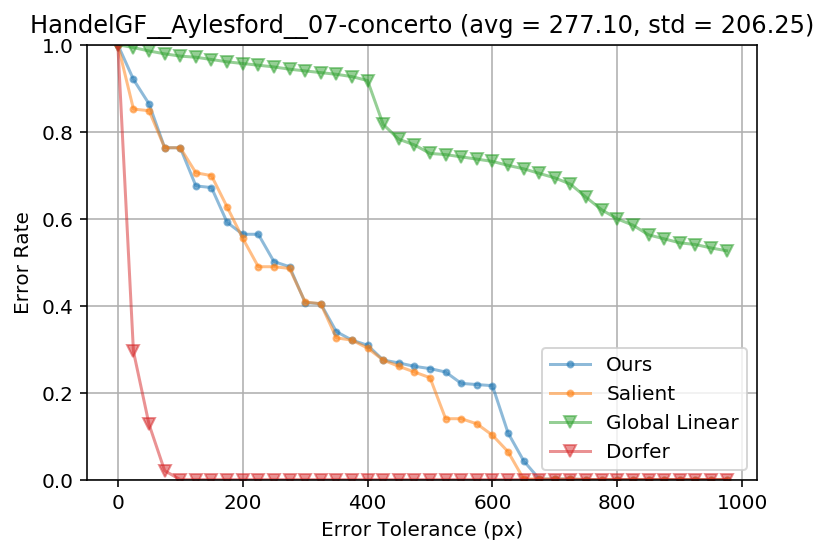

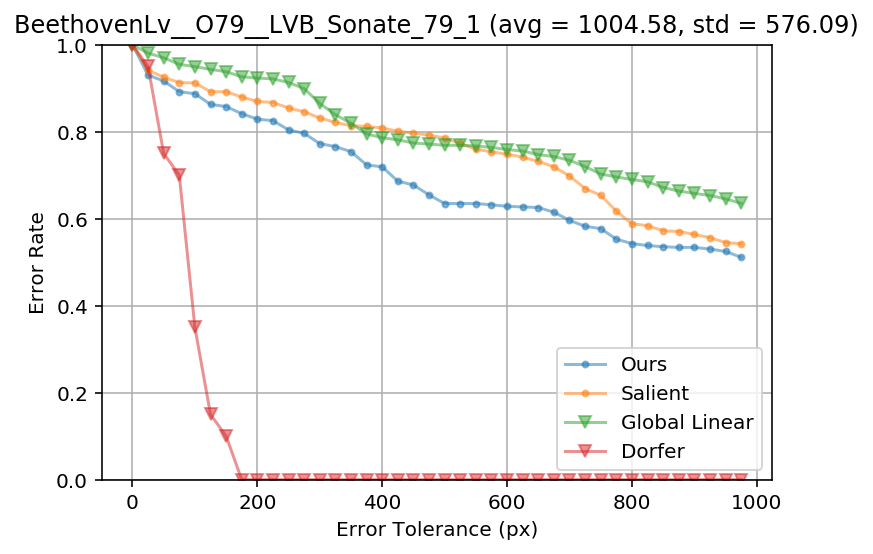

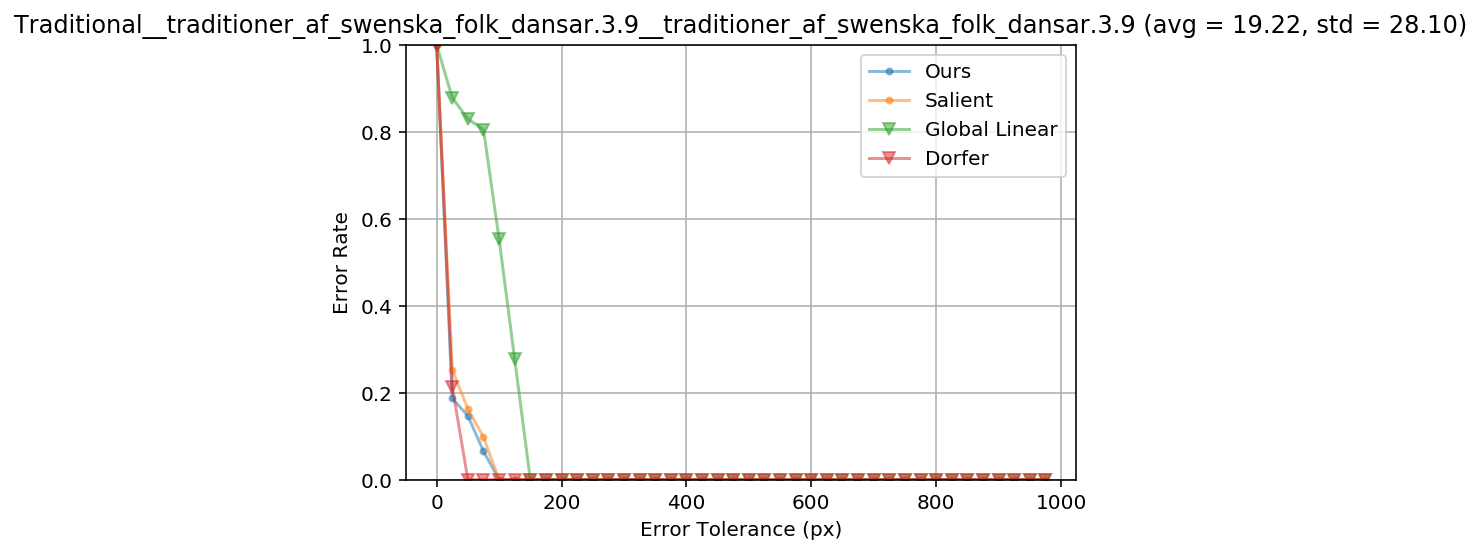

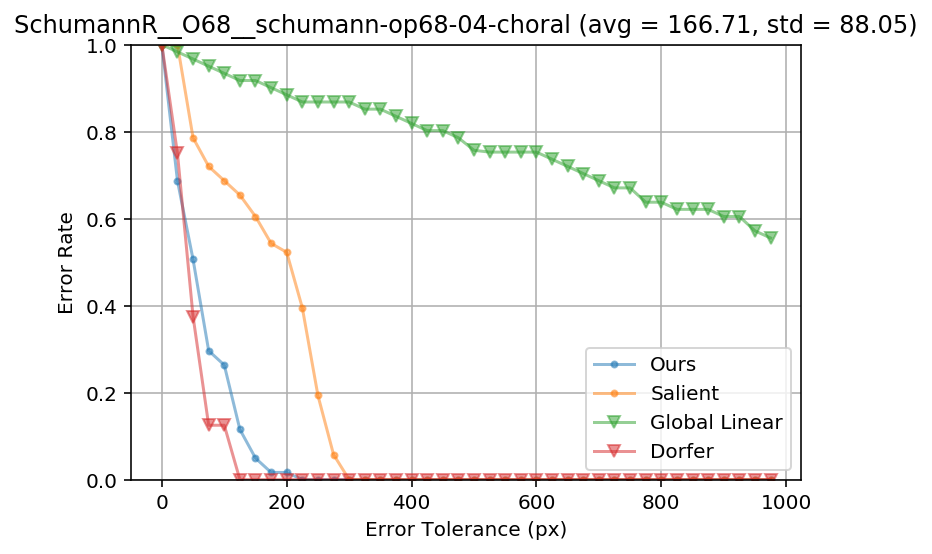

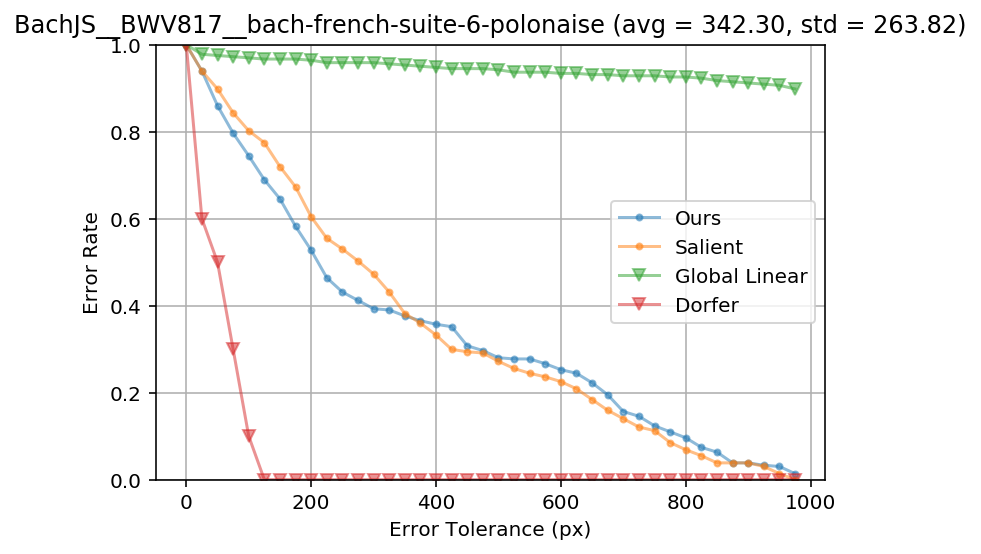

In [15]:
tols = np.arange(0,1000,25)
(ours, salient, global_linear, dorfer) = aggregateResult(output_dict, tols=tols, debug=True)

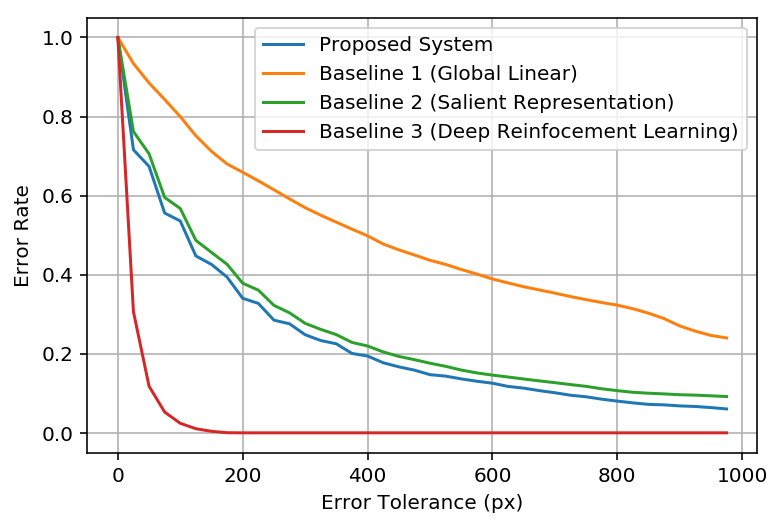

Proposed System: Average error: 249.12 px (std = 367.62)
Baseline 1 (Global Linear): Average error: 623.34 px (std = 631.68)
Baseline 2 (Salient Representation): Average error: 330.01 px (std = 540.36)
Baseline 3 (Deep Reinfocement Learning): Average error: 23.11 px (std = 25.52)


In [22]:
plt.plot(tols, ours[0], label='Proposed System')
plt.plot(tols, global_linear[0], label='Baseline 1 (Global Linear)')
plt.plot(tols, salient[0], label='Baseline 2 (Salient Representation)')
plt.plot(tols, dorfer[0], label='Baseline 3 (Deep Reinfocement Learning)')
plt.grid()
plt.legend()
plt.xlabel("Error Tolerance (px)")
plt.ylabel("Error Rate")
plt.savefig('final_result.png', dpi=300)
plt.show()
print("Proposed System: Average error: {:.2f} px (std = {:.2f})".format(ours[1], ours[2]))
print("Baseline 1 (Global Linear): Average error: {:.2f} px (std = {:.2f})".format(global_linear[1], global_linear[2]))
print("Baseline 2 (Salient Representation): Average error: {:.2f} px (std = {:.2f})".format(salient[1], salient[2]))
print("Baseline 3 (Deep Reinfocement Learning): Average error: {:.2f} px (std = {:.2f})".format(dorfer[1], dorfer[2]))

In [25]:
tols, ours[0]

(array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
        325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625,
        650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950,
        975]),
 [1.0,
  0.7160351436615896,
  0.6739373791512602,
  0.5559550866718681,
  0.5358390718816785,
  0.44740323620204214,
  0.42606601309406694,
  0.39380576003256557,
  0.34027612876963265,
  0.3274195189796126,
  0.28501645238983686,
  0.27582346755317344,
  0.24814274568336783,
  0.23348824586994132,
  0.22517724481834525,
  0.20078700091590623,
  0.19427388988771668,
  0.17724481834526273,
  0.16693239255062925,
  0.15855354659248957,
  0.14712167983988603,
  0.1434580548865294,
  0.1364361070592625,
  0.13053360018996574,
  0.12551307710573628,
  0.11743953322704298,
  0.11306353675497811,
  0.10678788289969131,
  0.10139421282947182,
  0.09511855897418502,
  0.09118355439465382,
  0.08514535771226975,
  0.08022660198785576,
  0.07578276060924725,
  0.072